# Consommation énergie

## Objectifs: 


    - Tester différents modèles, choisir le plus pertinents
    - Observer l'influence de l'ENERGYSTAR Score
    - Evaluer et definir les hyperparamètres du modèle

### Sommaire

    - Imports et fonctions
    
#### 1 - Consommation d'énergie sans ENERGYSTAR Score
    - Tests des modèles pour prédire la consommation d'énergie sans ENERGYSTAR Score
    - Comparaison
#### 2 - Consommation d'énergie avec ENERGYSTAR Score
    - Tests des modèles pour prédire la consommation d'énergie avec ENERGYSTAR Score
    - Comparaison
#### 3 - Comparaison et Visualisation

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

import scipy.stats as st
from statsmodels.formula.api import ols
from scipy.stats import loguniform
import re

from sklearn import preprocessing, model_selection, impute
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.compose import make_column_transformer
from sklearn import linear_model
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn import neighbors, metrics

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from math import *

import seaborn as sns

import warnings

In [2]:
warnings.filterwarnings("ignore")

#### Dimensions dataframme

In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

#### Données

In [4]:
data = pd.read_csv("./Data/DonnéesNettoyées.csv")

In [5]:
data.head()

,Unnamed: 0,OSEBuildingID,PropertyName,BuildingType,PrimaryPropertyType,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,CouncilDistrictCode,Neighborhood,Latitude,Longitude,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,YearsOld,NumberUses,%LargestUseGFA,%SecondUseGFA,%ThirdUseGFA,%BuildingGFA,%ParkingGFA
0,0,1,Mayflower park hotel,NonResidential,Hotel,Hotel,Hotel,88434.0,NotOtherUse,0.0,NotOtherUse,0.0,7,DOWNTOWN,47.61220,-122.33799,2016,1927,1.0,12,88434,0,88434,60.0,7226362.5,249.98,89,1.0,1.00,0.00,0.00,1.00,0.00
1,1,2,Paramount Hotel,NonResidential,Hotel,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,7,DOWNTOWN,47.61317,-122.33393,2016,1996,1.0,11,103566,15064,88502,61.0,8387933.0,295.86,20,3.0,0.81,0.15,0.04,0.85,0.15
2,2,3,5673-The Westin Seattle,NonResidential,Hotel,Hotel,Hotel,756493.0,NotOtherUse,0.0,NotOtherUse,0.0,7,DOWNTOWN,47.61393,-122.33810,2016,1969,1.0,41,956110,196718,759392,43.0,72587024.0,2089.28,47,1.0,0.79,0.00,0.00,0.79,0.21
3,3,5,HOTEL MAX,NonResidential,Hotel,Hotel,Hotel,61320.0,NotOtherUse,0.0,NotOtherUse,0.0,7,DOWNTOWN,47.61412,-122.33664,2016,1926,1.0,10,61320,0,61320,56.0,6794584.0,286.43,90,1.0,1.00,0.00,0.00,1.00,0.00
4,4,8,WARWICK SEATTLE HOTEL (ID8),NonResidential,Hotel,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,7,DOWNTOWN,47.61375,-122.34047,2016,1980,1.0,18,175580,62000,113580,75.0,14172606.0,505.01,36,3.0,0.70,0.39,0.00,0.65,0.35


### Features et targets

In [6]:
X = data[['PrimaryPropertyType',
          'YearsOld',
          'NumberofBuildings',
          'NumberofFloors',
          'PropertyGFATotal',
          'NumberUses',
          'ENERGYSTARScore',
          'LargestPropertyUseTypeGFA',
          'SecondLargestPropertyUseTypeGFA',
          'ThirdLargestPropertyUseTypeGFA',
          'PropertyGFAParking',
          'PropertyGFABuilding(s)'
         ]]

y= data['SiteEnergyUse(kBtu)']

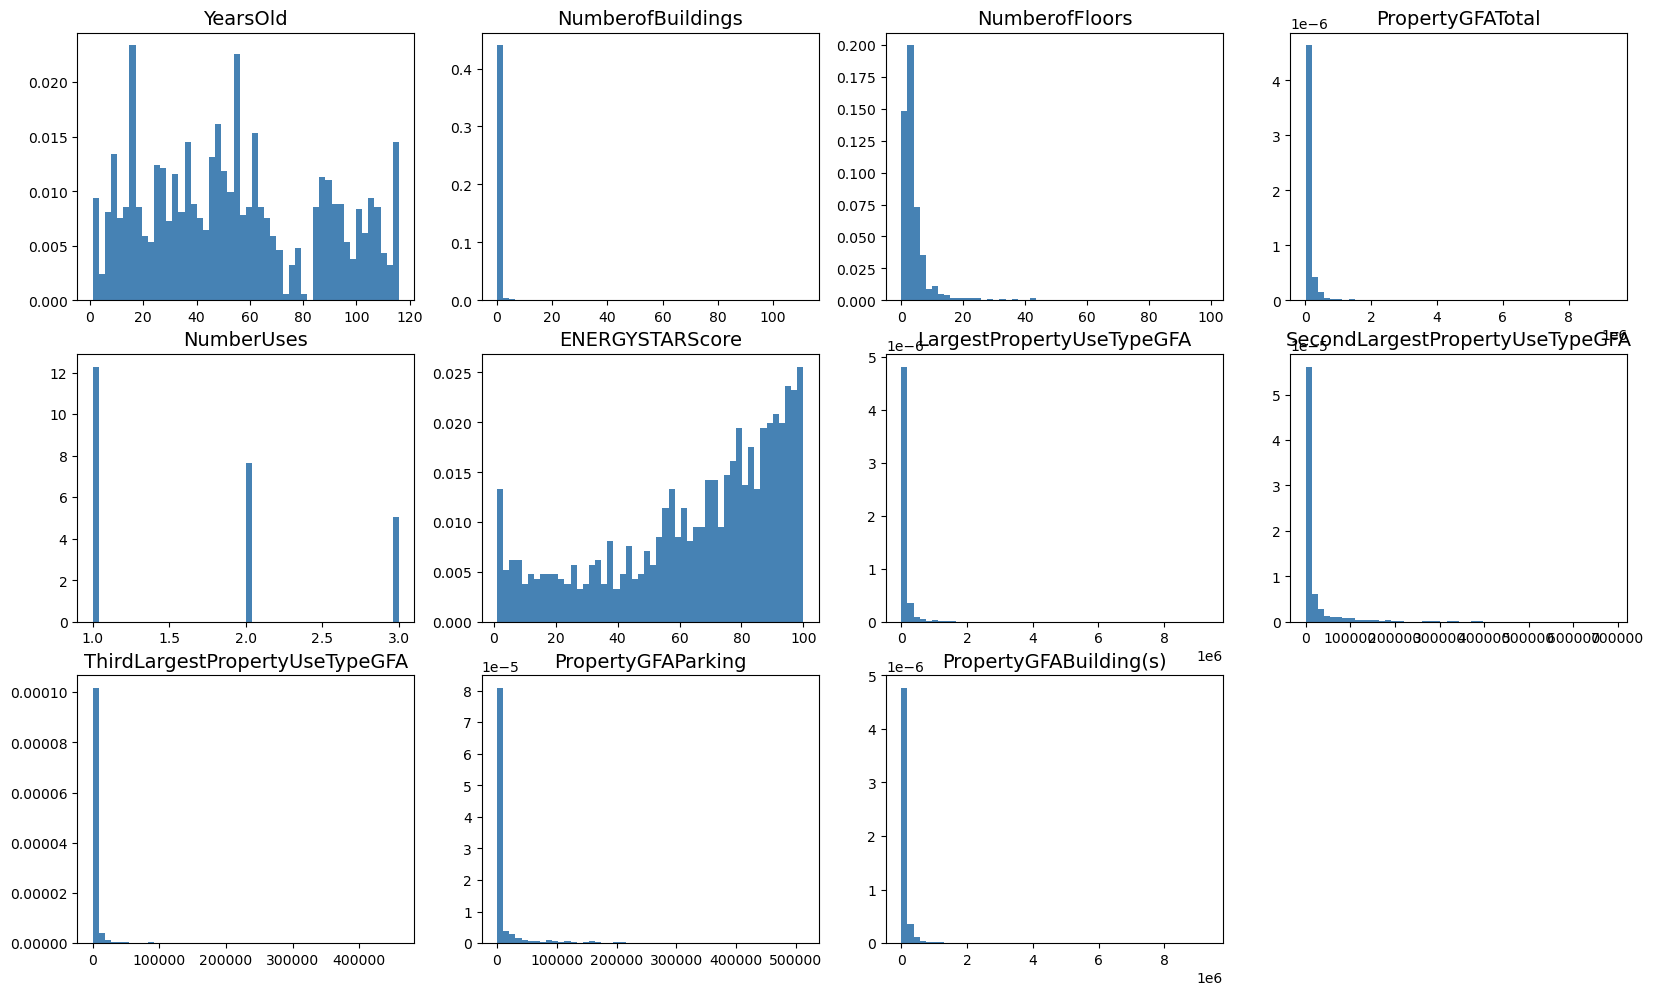

In [7]:
X_b = X.drop(['PrimaryPropertyType'],axis=1).values

fig = plt.figure(figsize=(20, 16))
for feat_idx in range(X_b.shape[1]):
    ax = fig.add_subplot(4,4, (feat_idx+1))
    h = ax.hist(X_b[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(X.drop(['PrimaryPropertyType'],axis=1).columns[feat_idx], fontsize=14)
plt.show()

In [8]:
X_s = preprocessing.StandardScaler().fit_transform(X.drop(['PrimaryPropertyType'],axis=1))

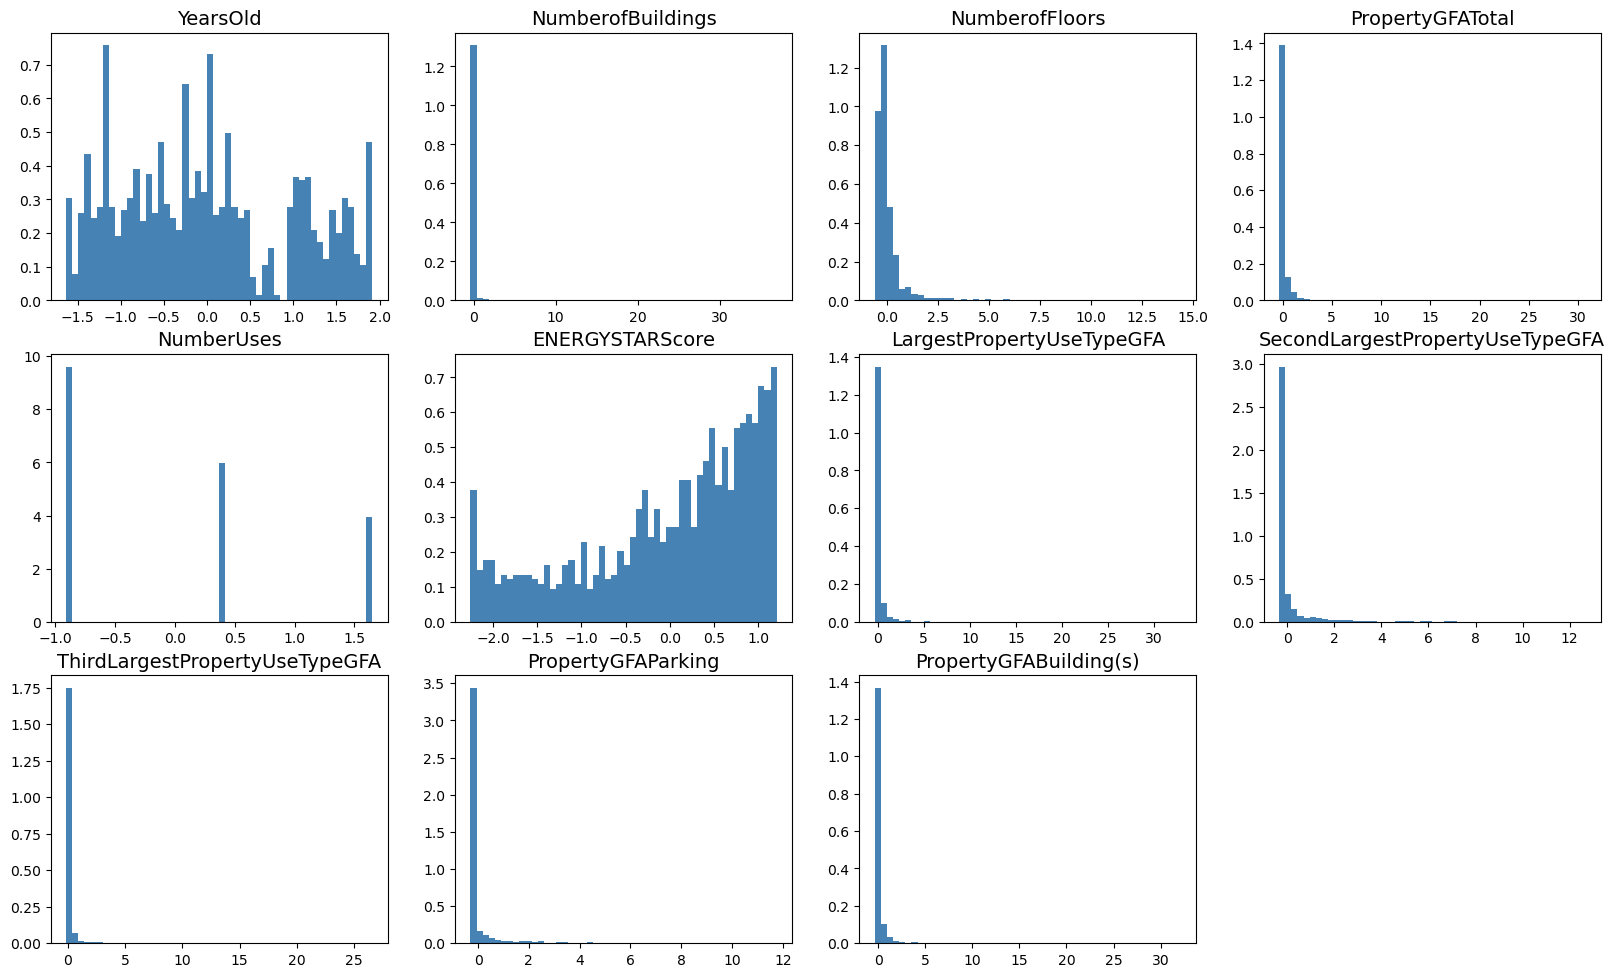

In [9]:
fig = plt.figure(figsize=(20, 16))
for feat_idx in range(X_s.shape[1]):
    ax = fig.add_subplot(4,4, (feat_idx+1))
    h = ax.hist(X_s[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(X.drop(['PrimaryPropertyType'],axis=1).columns[feat_idx], fontsize=14)
plt.show()

In [10]:
X_r = preprocessing.RobustScaler().fit_transform(X.drop(['PrimaryPropertyType'],axis=1))

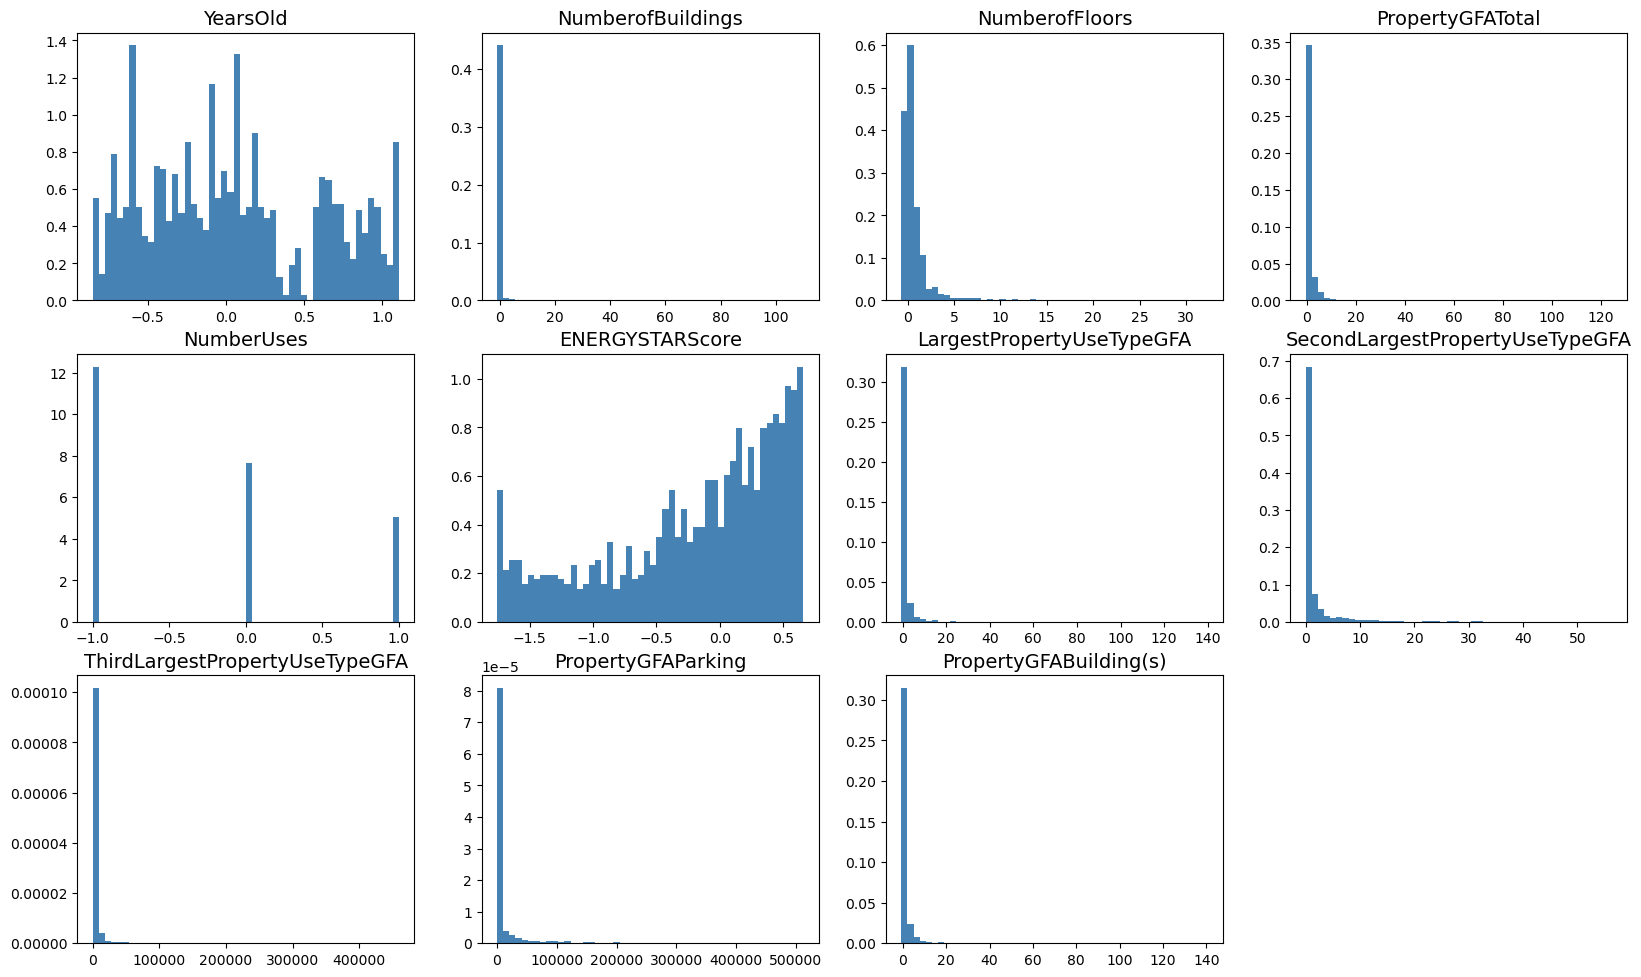

In [11]:
fig = plt.figure(figsize=(20, 16))
for feat_idx in range(X_r.shape[1]):
    ax = fig.add_subplot(4,4, (feat_idx+1))
    h = ax.hist(X_r[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(X.drop(['PrimaryPropertyType'],axis=1).columns[feat_idx], fontsize=14)
plt.show()

#### Transformation log pour la target

In [12]:
y_log = np.log1p(y)

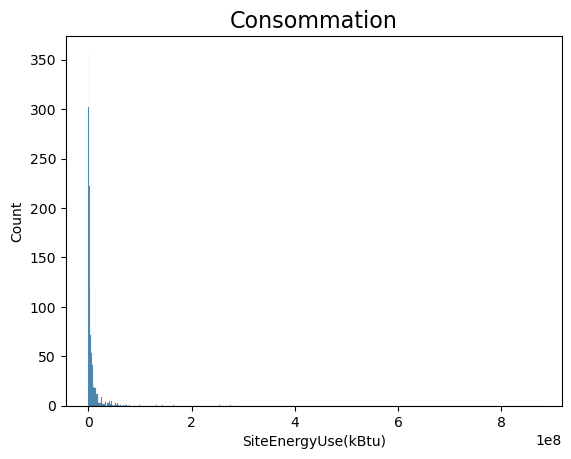

In [13]:
sns.histplot(y)
plt.title("Consommation", fontsize=16)
plt.savefig("./Visualisations/Consommation", bbox_inches='tight')

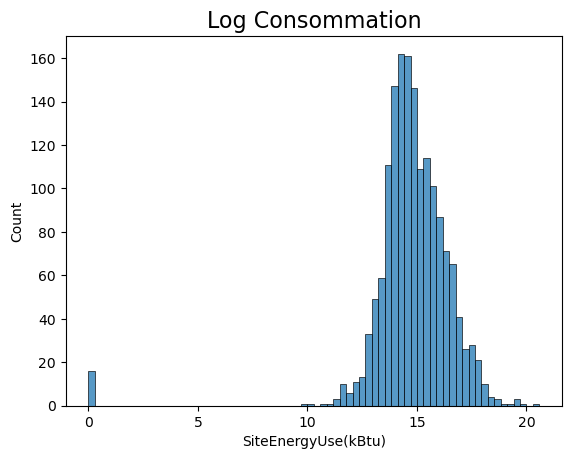

In [14]:
sns.histplot(y_log)
plt.title("Log Consommation", fontsize=16)
plt.savefig("./Visualisations/Log Consommation", bbox_inches='tight')

#### Folds pour cross validation

In [15]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 10,random_state = 3)

#### Fonction utilisée

In [16]:
def modelCV (Xtrain, Xtest, ytrain, ytest, mod, param_dict, cv, rand):
    
    # Fonction qui retourne les targets predites, un dataframe avec le temps d'éxécution et les métrics avec les meilleurs
    # paramètres de l'estimateur, et un dataframme avec les résultats de la cross validation.
    
    quant = Xtrain.select_dtypes(exclude =['object']).columns
    qual = Xtrain.select_dtypes(include =['object']).columns
    
    #Transformation et Encodage
    simple= impute.SimpleImputer()
    power = preprocessing.StandardScaler()
    encoder = preprocessing.OneHotEncoder(handle_unknown = 'ignore')

    pipeline_poly = Pipeline([('simple',simple),
                              ("power", power)])

    #Transformation de colonnes
    preprocessor = ColumnTransformer(
        transformers=[("quant", pipeline_poly, quant),
                      ("qual", encoder, qual)])

    #Pipeline modèle
    pipeline_mod = Pipeline([("preprocessor", preprocessor), 
                             ("model", mod)])
    
    scoring = {'MSE': 'neg_mean_squared_error', 'R²': 'r2'}
    
    if rand == True:
        search = RandomizedSearchCV(pipeline_mod, param_dict, 
                      cv=cv, 
                      scoring=scoring, refit='MSE', n_jobs=-1, n_iter=5, return_train_score=True)
        search.fit(Xtrain, ytrain)
        
    else:
        search = GridSearchCV(pipeline_mod, param_dict, 
                      cv=cv, 
                      scoring=scoring, refit='MSE', n_jobs=-1, return_train_score=True)
        search.fit(Xtrain, ytrain)
        
    yt_pred = search.predict(Xtrain)
    ypred = search.predict(Xtest)
    
        
    #Visualisation des prédictions par rapport aux valeurs réelles, afiichage de MSE et R²
    best = search.best_params_ #Meilleurs parametres
    mset = abs(search.best_score_) #MSE Train
    #r2 = search.best_estimator_.score(Xtrain, ytrain)#R² train
    #r2t = search.best_estimator_.score(Xtest, ytest) #R² test
    r2t = metrics.r2_score(ytrain, yt_pred)#R² train
    r2 = metrics.r2_score(ytest, ypred) #R² test
    mse = metrics.mean_squared_error(ytest, ypred) #MSE Test
    rmset = metrics.mean_squared_error(ytrain, yt_pred, squared=False) #RMSE Train
    rmse = metrics.mean_squared_error(ytest, ypred, squared=False) #RMSE Test
    
    params =[]
    
    for cle, valeur in param_dict.items():
        params.append(cle)
        
    res = search.cv_results_
    df_res=pd.DataFrame(res)
    time = df_res["mean_fit_time"].loc[df_res["params"] == search.best_params_ ].values #Temps moyen d'execution
    time = time.tolist()
    
    result = [best, round(time[0],2), mset, mse, rmset, rmse, r2t, r2]
        
    return yt_pred, ypred, result, pd.DataFrame(search.cv_results_)

In [17]:
def VisuModel(df_res, df_res_e, param):

    # Fonction qui premet de visualiser les MSE et les R² des modèles
    
    res = df_res
    res_e = df_res_e
    
    #Mise en forme pour label
    x= re.split("__",param)
    y = re.split("_", x[1])
    if len(y)>1:
        name = y[0]+' '+y[1]
    else:
        name = x[1]

    plt.figure(figsize=(20,15))
    #MSE sans ENERGYSTAR Score
    plt.subplot(2, 2, 1)
    res[['mean_train_MSE','mean_test_MSE']] = abs(res[['mean_train_MSE','mean_test_MSE']])
    sns.pointplot(data=res, x= param, y='mean_train_MSE', label= 'Train Set', color='b')
    sns.pointplot(data=res, x= param, y='mean_test_MSE', label= 'Validation Set', color='g')
    plt.ylabel('Mean squared error', fontsize = 13)
    plt.xlabel(name, fontsize = 13)
    plt.title('Mean squared error sans ENERGYSTAR Score', fontsize = 16)
    plt.legend(loc='best')
    
    plt.subplot(2, 2, 2)
    #MSE avec ENERGYSTAR Score
    res_e[['mean_train_MSE','mean_test_MSE']] = abs(res_e[['mean_train_MSE','mean_test_MSE']])
    sns.pointplot(data=res_e, x= param, y='mean_train_MSE', label= 'Train Set', color='b')
    sns.pointplot(data=res_e, x= param, y='mean_test_MSE', label= 'Validation Set', color='g')
    plt.ylabel('Mean squared error', fontsize = 13)
    plt.xlabel(name, fontsize = 13)
    plt.title('Mean squared error avec ENERGYSTAR Score', fontsize = 16)
    plt.legend(loc='best')
    
    plt.subplot(2, 2, 3)
    #R² sans ENERGYSTAR Score
    sns.pointplot(data=res, x= param, y='mean_train_R²', label= 'Train Set', color='b')
    sns.pointplot(data=res, x= param, y='mean_test_R²', label= 'Validation Set', color='g')
    plt.ylabel('R²', fontsize = 13)
    plt.xlabel(name, fontsize = 13)
    plt.title('R² sans ENERGYSTAR Score', fontsize = 16)
    plt.legend(loc='best')
    
    plt.subplot(2, 2, 4)
    #R² avec ENERGYSTAR Score
    sns.pointplot(data=res_e, x= param, y='mean_train_R²', label= 'Train Set', color='b')
    sns.pointplot(data=res_e, x= param, y='mean_test_R²', label= 'Validation Set', color='g')
    plt.ylabel('R²', fontsize = 13)
    plt.xlabel(name, fontsize = 13)
    plt.title('R² avec ENERGYSTAR Score', fontsize = 16)
    plt.legend(loc='best')
    
    plt.show()

##  1 - Consomation énergie sans ENERGYSTAR Score

#### Split Entrainement / Test

In [18]:
#Sépare et Mélange le jeu de données
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X.drop('ENERGYSTARScore', axis=1), y_log,test_size=0.2, shuffle= True, random_state = 9)

#### Dataframe pour visualisation

In [19]:
df_modele = pd.DataFrame(columns = ['Best Param', 'Time', 'MSE_Train', 'MSE_Test','RMSE_Train', 'RMSE_Test', 'R² Train', 'R² Test'])

#### Ridge

In [20]:
param_ridge = {'model__alpha': list( np.arange(0, 50, 1))}

In [21]:
y_ridge, yt_ridge, result_ridge, cv_res_ridge = modelCV(Xtrain, Xtest, 
                                             ytrain, ytest, 
                                             linear_model.Ridge(random_state = 0), 
                                             param_ridge, cv, rand=False)
df_modele.loc['Ridge'] = result_ridge

#### Lasso 

In [22]:
param_lasso = {'model__alpha': list( np.arange(0, 10, .01)) }

In [23]:
y_lasso, yt_lasso, result_lasso, cv_res_lasso = modelCV(Xtrain, Xtest, 
                                             ytrain, ytest, 
                                             linear_model.Lasso(random_state = 0), 
                                             param_lasso, cv, rand=False) 
df_modele.loc['Lasso'] = result_lasso

#### Elastic Net

In [24]:
param_en = {'model__alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]}

In [25]:
y_en, yt_en, result_en, cv_res_en = modelCV(Xtrain, Xtest, 
                                             ytrain, ytest, 
                                             linear_model.ElasticNet(random_state = 0), 
                                             param_en, cv, rand=False) 
df_modele.loc['Elastic Net'] = result_en

### kNN Regressor

#### Parametres

In [26]:
knn = KNeighborsRegressor()
param_knn = {'model__n_neighbors': list( np.arange(1, 60, 1))}

#### GridSearchCV

In [27]:
y_knn, yt_knn, result_knn, cv_res_knn = modelCV(Xtrain, Xtest, ytrain, ytest, knn, param_knn, cv, rand=False)
df_modele.loc['kNN Regressor'] = result_knn

### SVR

#### Paramètres

In [28]:
svr = SVR()
param_svr = {'model__C': list( np.arange(0, 20 ,1)),
             'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
             'model__verbose':[True,False]}

#### GridSearchCV

In [29]:
y_svr, yt_svr, result_svr, cv_res_svr = modelCV(Xtrain, Xtest, ytrain, ytest, svr, param_svr, cv, rand=False) 
df_modele.loc['SVR'] = result_svr

[LibSVM]

### XGBoost Regressor

In [30]:
xgb = XGBRegressor(n_jobs=-1)
param_xgb = {"model__n_estimators" :list(np.arange(0,500,100)), 
             "model__max_depth" :list(np.arange(1,10,1))}

In [31]:
# GridSearchCV
y_xgb, yt_xgb, result_xgb, cv_res_xgb = modelCV(Xtrain, Xtest,
                                 ytrain,
                                 ytest,
                                 xgb, 
                                 param_xgb, 
                                 cv, 
                                 rand=False)
df_modele.loc['XGB Regressor'] = result_xgb

### LightGBM Regressor

In [32]:
lgbmr = LGBMRegressor(n_jobs=-1, random_state=0)
param_lgbmr ={"model__n_estimators" :list(np.arange(0,500,100)),
              "model__max_depth" :list(np.arange(1,10,1))}

In [33]:
# GridSearchCV
y_lgbm, yt_lgbm, result_lgbmr, cv_res_lgbmr =  modelCV(Xtrain, Xtest,
                                 ytrain,
                                 ytest,
                                 lgbmr, 
                                 param_lgbmr, 
                                 cv, 
                                 rand=False)
df_modele.loc['LGBM Regressor'] = result_lgbmr

### RandomForest

In [34]:
rfr = RandomForestRegressor()
param_rfr ={"model__n_estimators" :list(np.arange(0,500,100)),
             "model__max_depth" :list(np.arange(1,10,1))}

In [35]:
y_rfr, yt_rfr, result_rfr, cv_res_rfr = modelCV(Xtrain, Xtest,
                                 ytrain,
                                 ytest,
                                 rfr, 
                                 param_rfr, 
                                 cv, 
                                 rand=False) 
df_modele.loc['RF Regressor'] = result_rfr

#### Comparaison

In [36]:
df_modele

,Best Param,Time,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test,R² Train,R² Test
Ridge,{'model__alpha': 1},0.02,2.974340,6.512517,1.662099,2.551963,0.303815,-0.728460
Lasso,{'model__alpha': 0.0},0.09,2.974592,6.407732,1.661676,2.531350,0.304169,-0.700649
Elastic Net,{'model__alpha': 0.001},0.04,2.974534,6.539803,1.662305,2.557304,0.303641,-0.735701
kNN Regressor,{'model__n_neighbors': 14},0.02,2.749329,2.348128,1.532922,1.532360,0.407823,0.376793
SVR,"{'model__C': 5, 'model__kernel': 'rbf', 'model...",0.18,2.772841,2.551318,1.584249,1.597285,0.367503,0.322865
XGB Regressor,"{'model__max_depth': 1, 'model__n_estimators':...",0.23,2.861971,2.362283,1.483019,1.536972,0.445751,0.373037
LGBM Regressor,"{'model__max_depth': 2, 'model__n_estimators':...",0.05,2.667590,2.430495,1.536059,1.559004,0.405397,0.354933
RF Regressor,"{'model__max_depth': 5, 'model__n_estimators':...",1.63,2.931160,2.613363,1.276294,1.616590,0.589500,0.306398


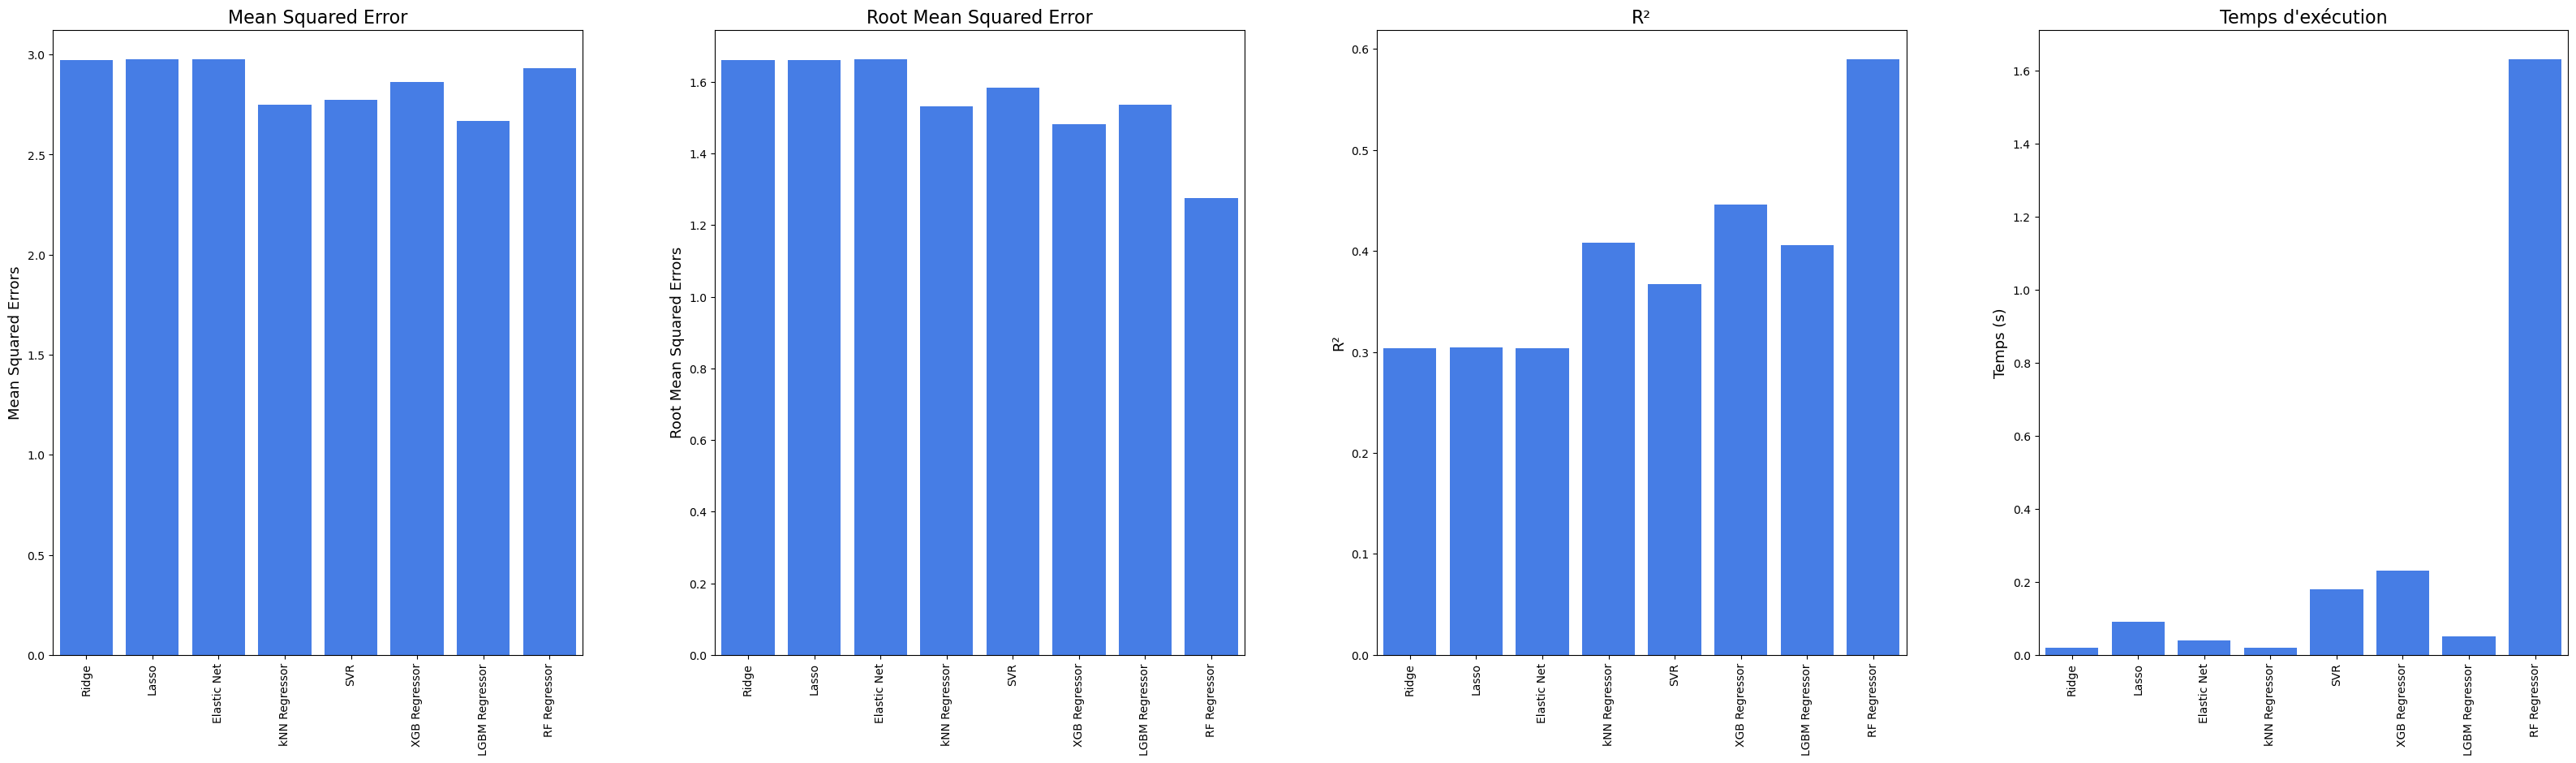

In [37]:
plt.figure(figsize = (40,10))
plt.subplot(1, 4, 1)
sns.barplot(data= df_modele, y=df_modele['MSE_Train'], x=df_modele.index, color="#2C75FF")
plt.title('Mean Squared Error', fontsize = 16)
plt.ylabel('Mean Squared Errors', fontsize = 13)
plt.xticks(rotation='vertical')

plt.subplot(1, 4, 2)
sns.barplot(data= df_modele, y=df_modele['RMSE_Train'], x=df_modele.index,color="#2C75FF" )
plt.title('Root Mean Squared Error', fontsize = 16)
plt.ylabel('Root Mean Squared Errors', fontsize = 13)
plt.xticks(rotation='vertical')


plt.subplot(1, 4, 3)
sns.barplot(data= df_modele, y=df_modele['R² Train'], x=df_modele.index,color="#2C75FF" )
plt.title('R²', fontsize = 16)
plt.ylabel('R²', fontsize = 13)
plt.xticks(rotation='vertical')


plt.subplot(1, 4, 4)
sns.barplot(data= df_modele, y=df_modele['Time'], x=df_modele.index,color="#2C75FF")
plt.title("Temps d'exécution", fontsize = 16)
plt.ylabel('Temps (s)', fontsize = 13)
plt.xticks(rotation='vertical')

plt.subplots_adjust(hspace=0.45,wspace=0.25)
plt.savefig("./Visualisations/modele conso", bbox_inches='tight')
plt.show()


## 2 - Consomation énergie avec ENERGYSTAR Score

#### Split Entrainement / Test

In [38]:
#Sépare et Mélange le jeu de données
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_log,test_size=0.2, shuffle= True, random_state = 11)

#### Dataframe pour visualisation

In [39]:
df_modele_e = pd.DataFrame(columns = ['Best Param', 'Time', 'MSE_Train', 'MSE_Test','RMSE_Train', 'RMSE_Test', 'R² Train', 'R² Test'])

#### Ridge

In [40]:
y_ridge_e, yt_ridge_e, result_ridge_e, cv_res_ridge_e = modelCV(X_train, X_test, 
                                             y_train, y_test, 
                                             linear_model.Ridge(random_state = 3), 
                                             param_ridge, cv, rand=False)
df_modele_e.loc['Ridge'] = result_ridge_e

#### Lasso 

In [41]:
y_lasso_e, yt_lasso_e, result_lasso_e, cv_res_lasso_e = modelCV(X_train, X_test, 
                                             y_train, y_test, 
                                             linear_model.Lasso(random_state = 3), 
                                             param_lasso, cv, rand=False) 
df_modele_e.loc['Lasso'] = result_lasso_e

#### Elastic Net

In [42]:
y_en_e, yt_en_e, result_en_e, cv_res_en_e = modelCV(X_train, X_test, 
                                             y_train, y_test, 
                                             linear_model.ElasticNet(random_state = 3), 
                                             param_en, cv, rand=False) 
df_modele_e.loc['Elastic Net'] = result_en_e

### kNN Regressor

#### Parametres

In [43]:
knn = KNeighborsRegressor()

In [44]:
y_knn_e, yt_knn_e, result_knn_e, cv_res_knn_e = modelCV(X_train, X_test, 
                                             y_train, y_test, knn, param_knn, cv, rand=False)
df_modele_e.loc['kNN Regressor'] = result_knn_e

### SVR

#### Paramètres

In [45]:
svr = SVR()

#### GridSearchCV

In [46]:
y_svr_e, yt_svr_e, result_svr_e, cv_res_svr_e = modelCV(X_train, X_test, 
                                             y_train, y_test, svr, param_svr, cv, rand=False) 
df_modele_e.loc['SVR'] = result_svr_e

[LibSVM]

### XGBoost Regressor

In [47]:
xgb = XGBRegressor(n_jobs=-1)

In [48]:
# GridSearchCV
y_xgb_e, yt_xgb_e, result_xgb_e, cv_res_xgb_e = modelCV(X_train, X_test,
                                 y_train,
                                 y_test,
                                 xgb, 
                                 param_xgb, 
                                 cv, 
                                 rand=False)
df_modele_e.loc['XGB Regressor'] = result_xgb_e

### LightGBM Regressor

In [49]:
lgbmr = LGBMRegressor(n_jobs=-1)

In [50]:
# GridSearchCV
y_lgbmr_e, yt_lgbmr_e,result_lgbmr_e, cv_res_lgbmr_e =  modelCV(X_train, X_test,
                                 y_train,
                                 y_test,
                                 lgbmr, 
                                 param_lgbmr, 
                                 cv, 
                                 rand=False)
df_modele_e.loc['LGBM Regressor'] = result_lgbmr_e

### RandomForest

In [51]:
rfr = RandomForestRegressor(n_jobs=-1)

In [52]:
y_rfr_e, yt_rfr_e, result_rfr_e, cv_res_rfr_e = modelCV(X_train, X_test,
                                 y_train,
                                 y_test,
                                 rfr, 
                                 param_rfr, 
                                 cv, 
                                 rand=False) 
df_modele_e.loc['RF Regressor'] = result_rfr_e

#### Comparaison

In [53]:
df_modele_e

,Best Param,Time,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test,R² Train,R² Test
Ridge,{'model__alpha': 1},0.08,4.119015,2.237249,1.704428,1.495744,0.303395,0.244833
Lasso,{'model__alpha': 0.18},0.06,3.834655,2.544736,1.879010,1.595223,0.153382,0.141042
Elastic Net,{'model__alpha': 0.1},0.02,4.003408,2.452086,1.815179,1.565914,0.209925,0.172316
kNN Regressor,{'model__n_neighbors': 4},0.03,2.551560,1.012305,1.232419,1.006134,0.635795,0.658304
SVR,"{'model__C': 9, 'model__kernel': 'rbf', 'model...",0.40,2.884801,1.746366,1.594504,1.321501,0.390350,0.410527
XGB Regressor,"{'model__max_depth': 4, 'model__n_estimators':...",0.84,1.660958,0.524287,0.365732,0.724077,0.967926,0.823031
LGBM Regressor,"{'model__max_depth': 3, 'model__n_estimators':...",0.22,1.826943,0.705434,0.880075,0.839901,0.814276,0.761886
RF Regressor,"{'model__max_depth': 9, 'model__n_estimators':...",2.63,1.989170,0.452179,0.694480,0.672443,0.884349,0.847370


## 3 - Comparaison et Visualisation

### Comparaison des modèles avec et sans l'ENERGYSTAR Score

 - Attribution d'une colonne pour l'ENERGYSTAR Score

In [54]:
df_modele['ENERGYSTAR Score'] = 'Sans'
df_modele_e['ENERGYSTAR Score'] = 'Avec'

- Assemblage des dataframes

In [55]:
df_modeles = pd.concat([df_modele, df_modele_e], axis=0, ignore_index=False)

In [56]:
df_modeles.to_csv("./Data/Conso_modeles.csv")

#### Visualisations

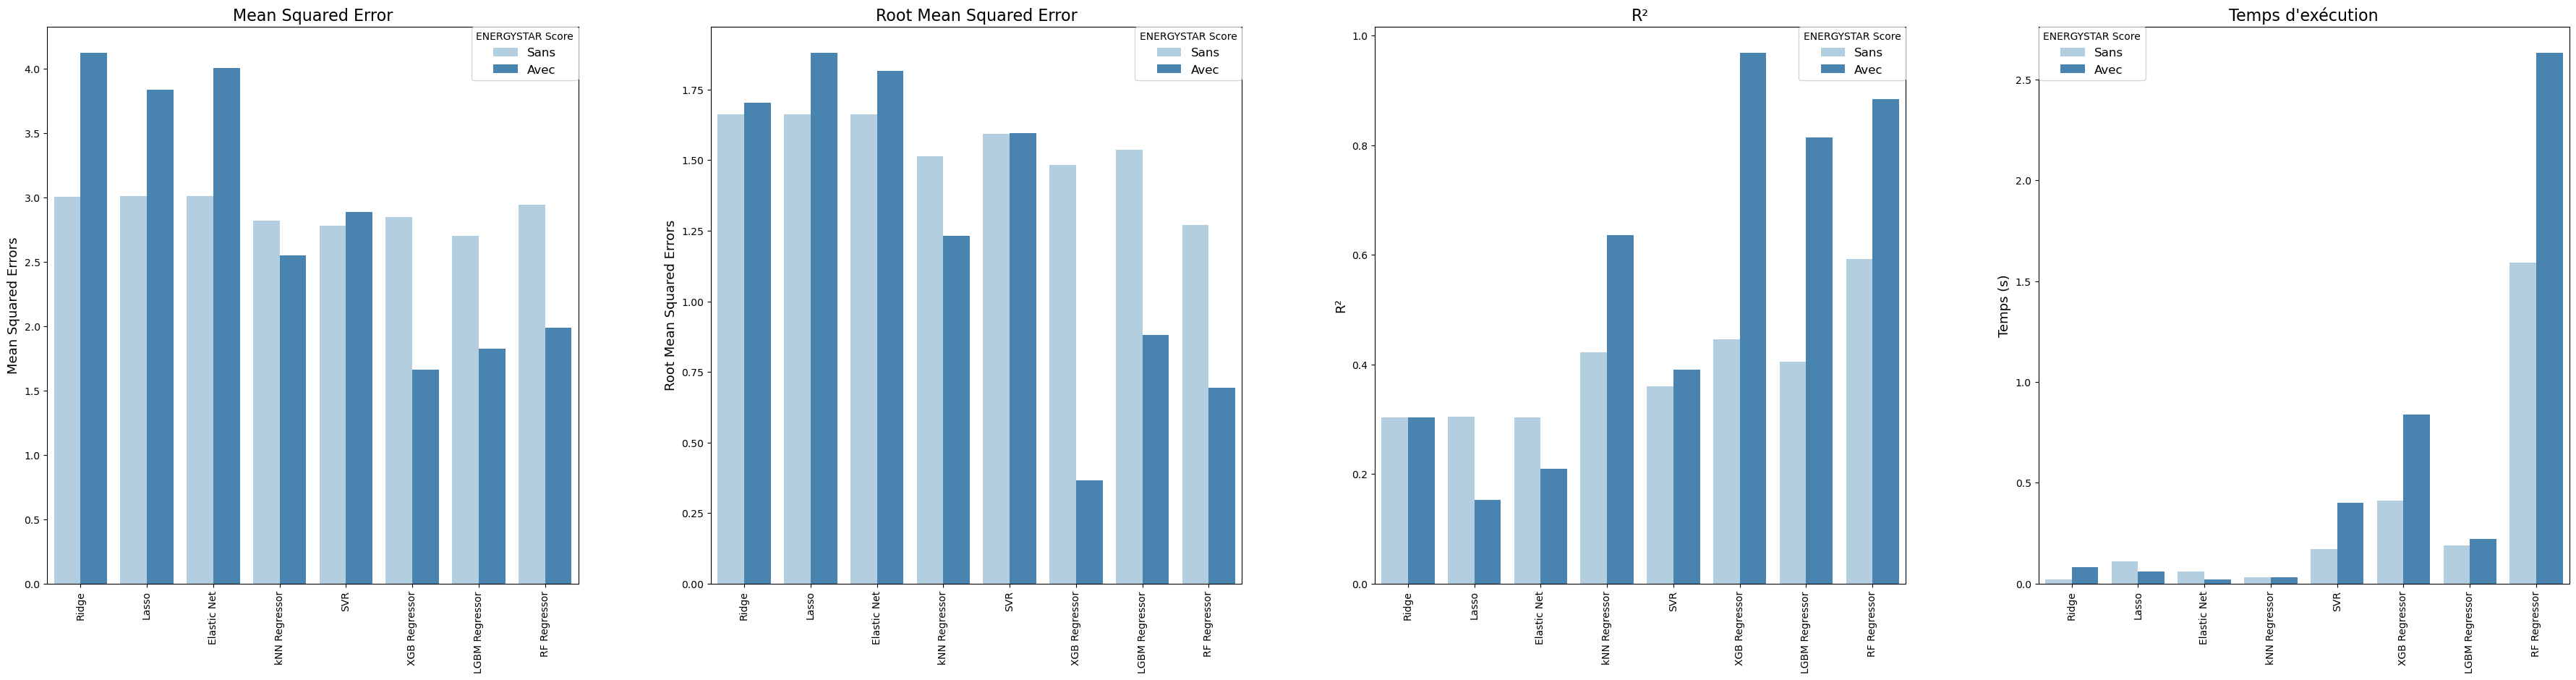

In [57]:
plt.figure(figsize = (45,10))
plt.subplot(1, 4, 1)
sns.barplot(data= df_modeles, y=df_modeles['MSE_Train'], x=df_modeles.index, hue='ENERGYSTAR Score',palette='Blues')
plt.title('Mean Squared Error', fontsize = 16)
plt.ylabel('Mean Squared Errors', fontsize = 13)
plt.legend(title='ENERGYSTAR Score', loc='best', borderaxespad=0., fontsize=12)
plt.xticks(rotation='vertical')

plt.subplot(1, 4, 2)
sns.barplot(data= df_modeles, y=df_modeles['RMSE_Train'], x=df_modeles.index, hue='ENERGYSTAR Score',palette='Blues' )
plt.title('Root Mean Squared Error', fontsize = 16)
plt.ylabel('Root Mean Squared Errors', fontsize = 13)
plt.legend(title='ENERGYSTAR Score',  loc='best', borderaxespad=0., fontsize=12)
plt.xticks(rotation='vertical')

plt.subplot(1, 4, 3)
sns.barplot(data= df_modeles, y=df_modeles['R² Train'], x=df_modeles.index, hue='ENERGYSTAR Score' ,palette='Blues' )
plt.title('R²', fontsize = 16)
plt.ylabel('R²', fontsize = 13)
plt.legend(title='ENERGYSTAR Score', loc='best', borderaxespad=0., fontsize=12)
plt.xticks(rotation='vertical')

plt.subplot(1, 4, 4)
sns.barplot(data= df_modeles, y=df_modeles['Time'], x=df_modeles.index, hue='ENERGYSTAR Score',palette='Blues' )
plt.title("Temps d'exécution", fontsize = 16)
plt.ylabel('Temps (s)', fontsize = 13)
plt.legend(title='ENERGYSTAR Score', loc='best', borderaxespad=0., fontsize=12)
plt.xticks(rotation='vertical')

plt.subplots_adjust(hspace=0.45,wspace=0.25)
plt.savefig("./Visualisations/comparaison modele conso", bbox_inches='tight')
plt.show()


### Choix et comparaison des 3 modèles sélectionnés

#### XGB Regressor

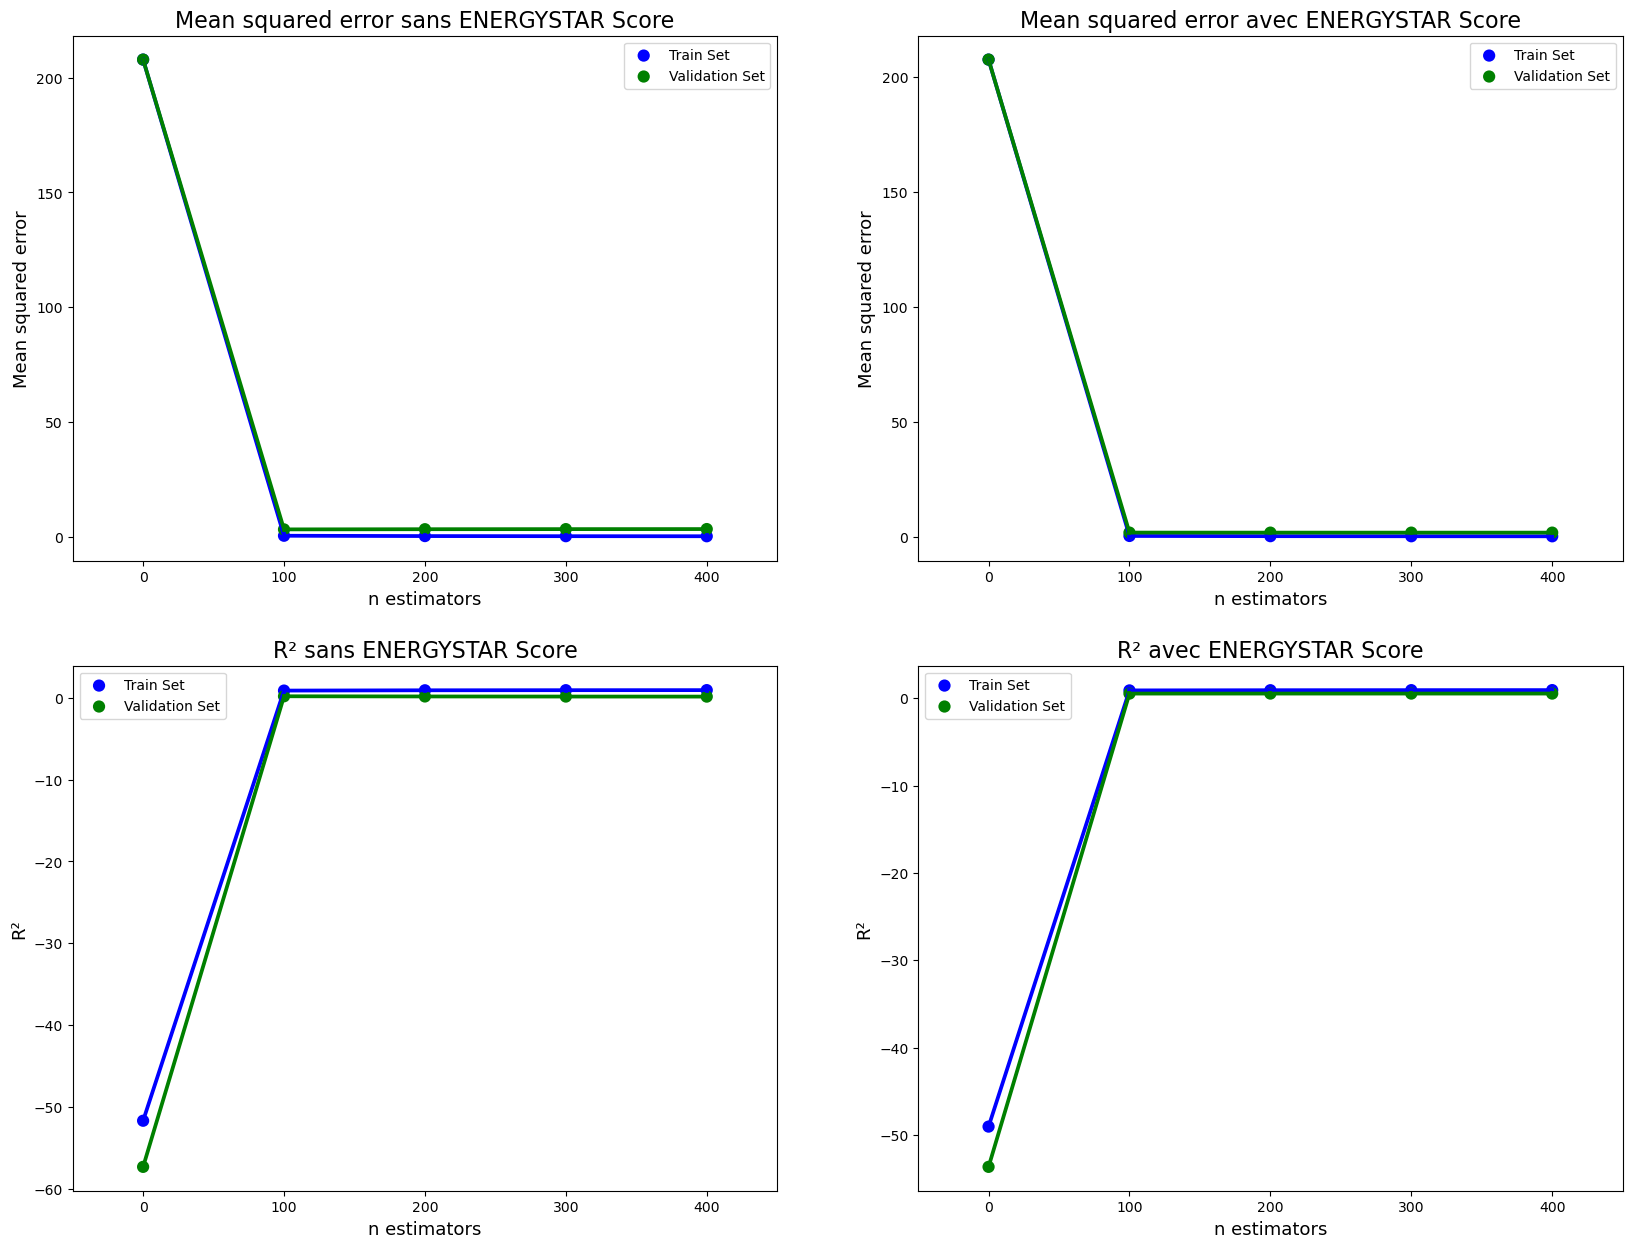

In [58]:
VisuModel(cv_res_xgb, cv_res_xgb_e, 'param_model__n_estimators' )

Text(0.5, 1.0, 'Préditictions en fonction des valeurs réelles (Test)')

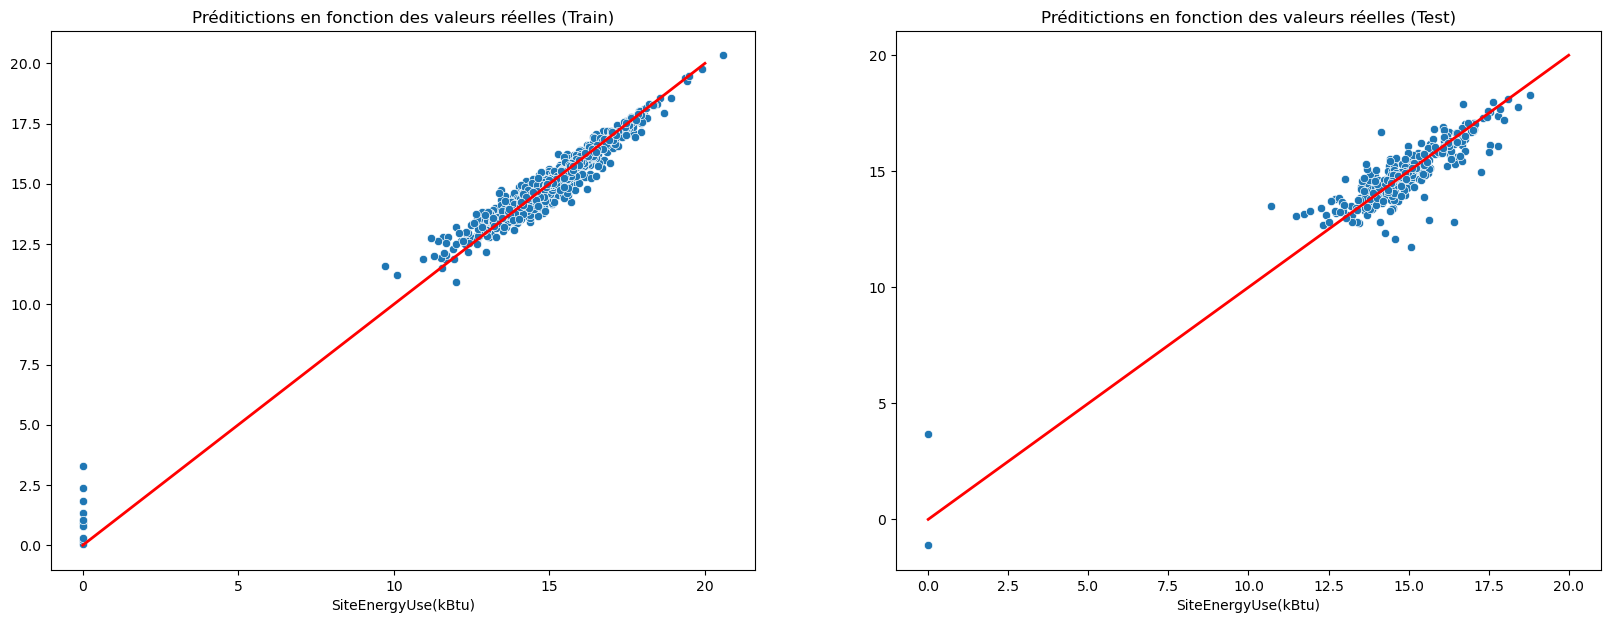

In [59]:
plt.figure(figsize = (20,7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y= y_xgb_e)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Train)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y= yt_xgb_e)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Test)')

#### LGBM Regressor

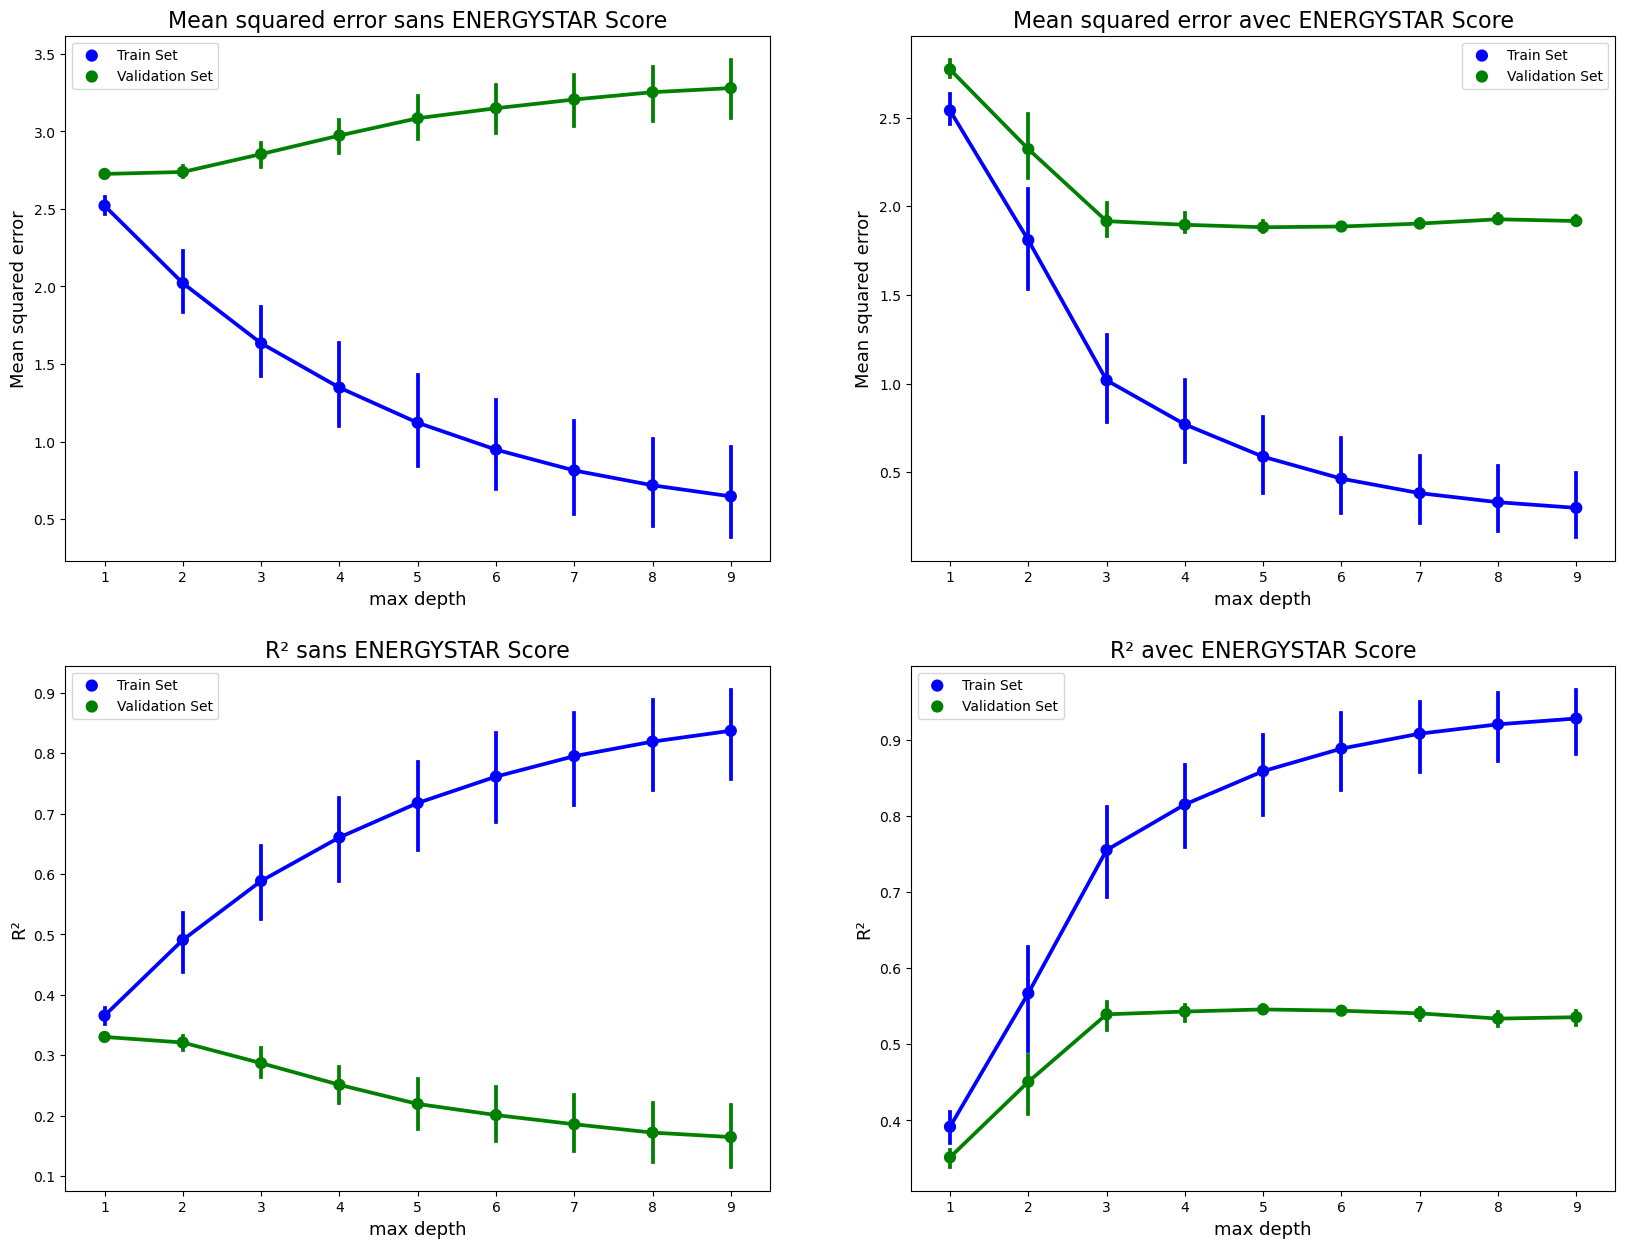

In [60]:
VisuModel(cv_res_lgbmr, cv_res_lgbmr_e, 'param_model__max_depth' )

Text(0.5, 1.0, 'Préditictions en fonction des valeurs réelles (Test)')

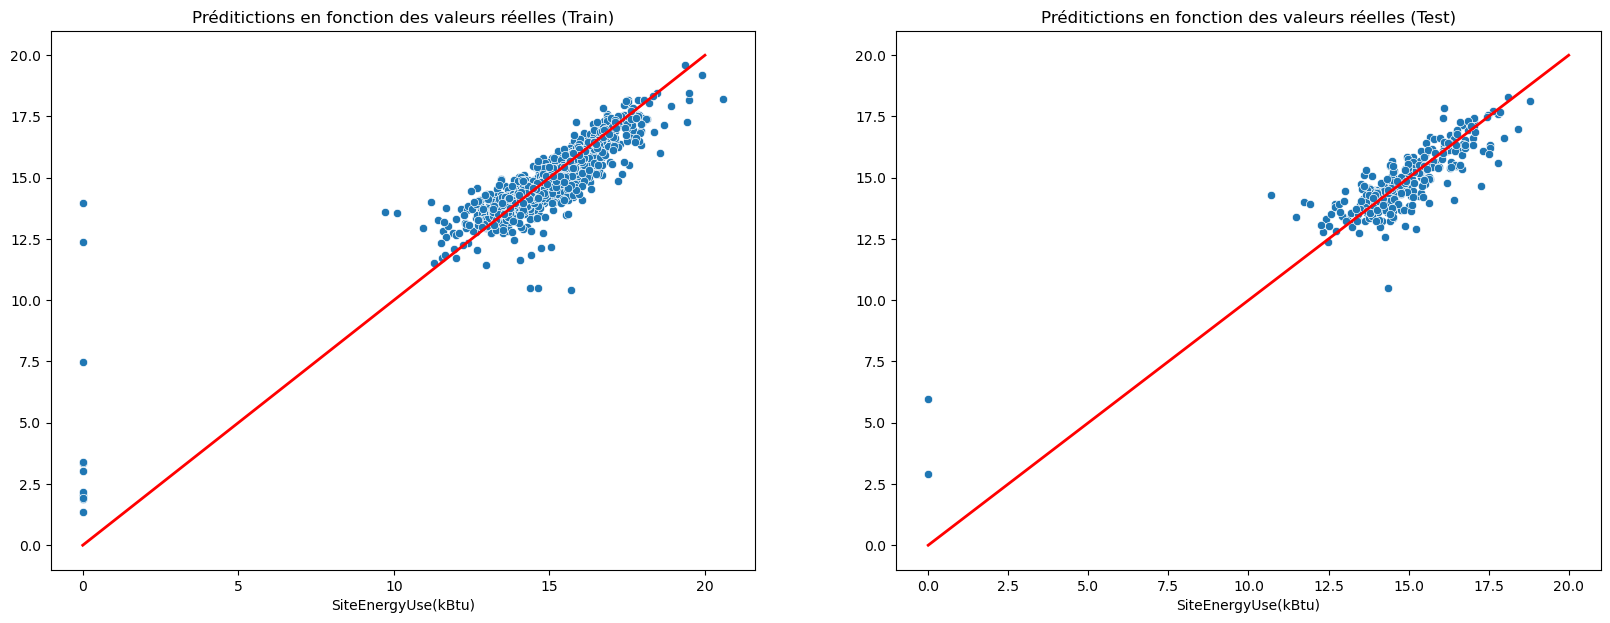

In [61]:
plt.figure(figsize = (20,7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y= y_lgbmr_e)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Train)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y= yt_lgbmr_e)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Test)')

#### Random Forest Regressor

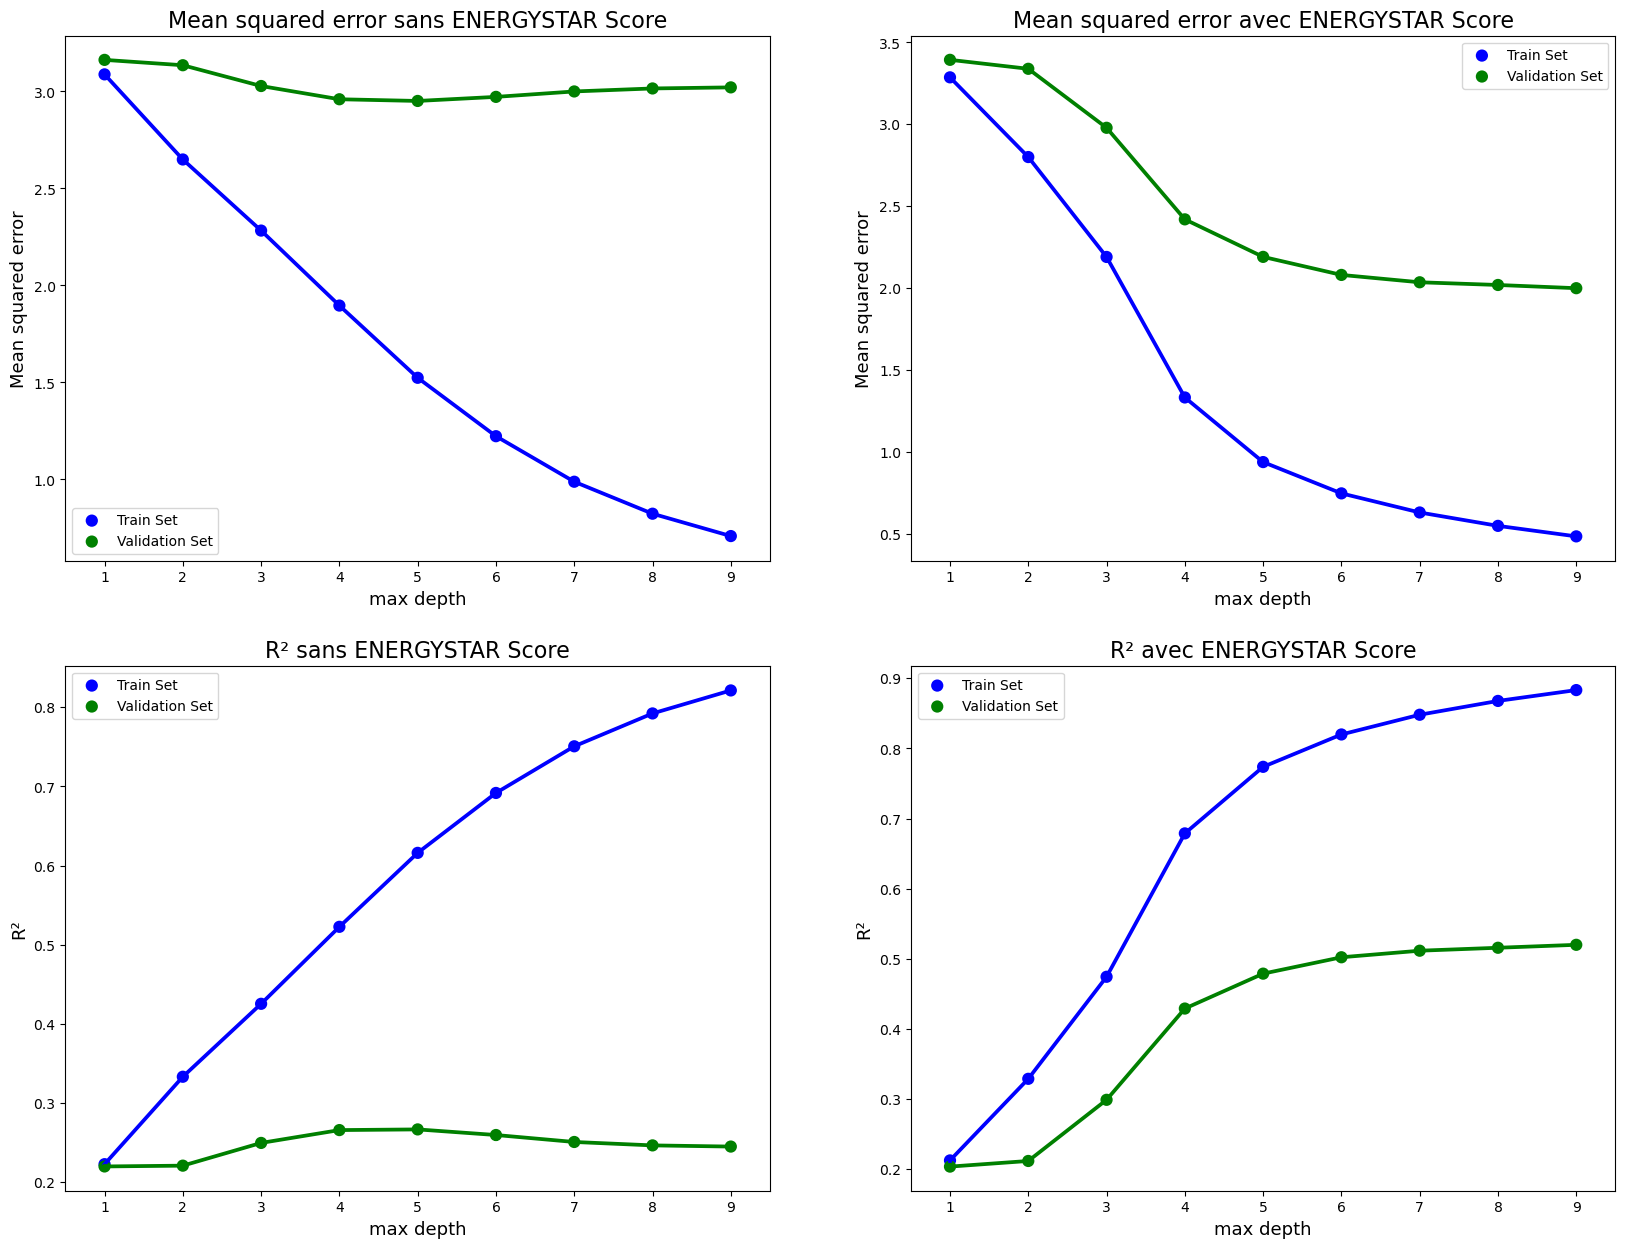

In [62]:
VisuModel(cv_res_rfr, cv_res_rfr_e, 'param_model__max_depth' )

Text(0.5, 1.0, 'Préditictions en fonction des valeurs réelles (Test)')

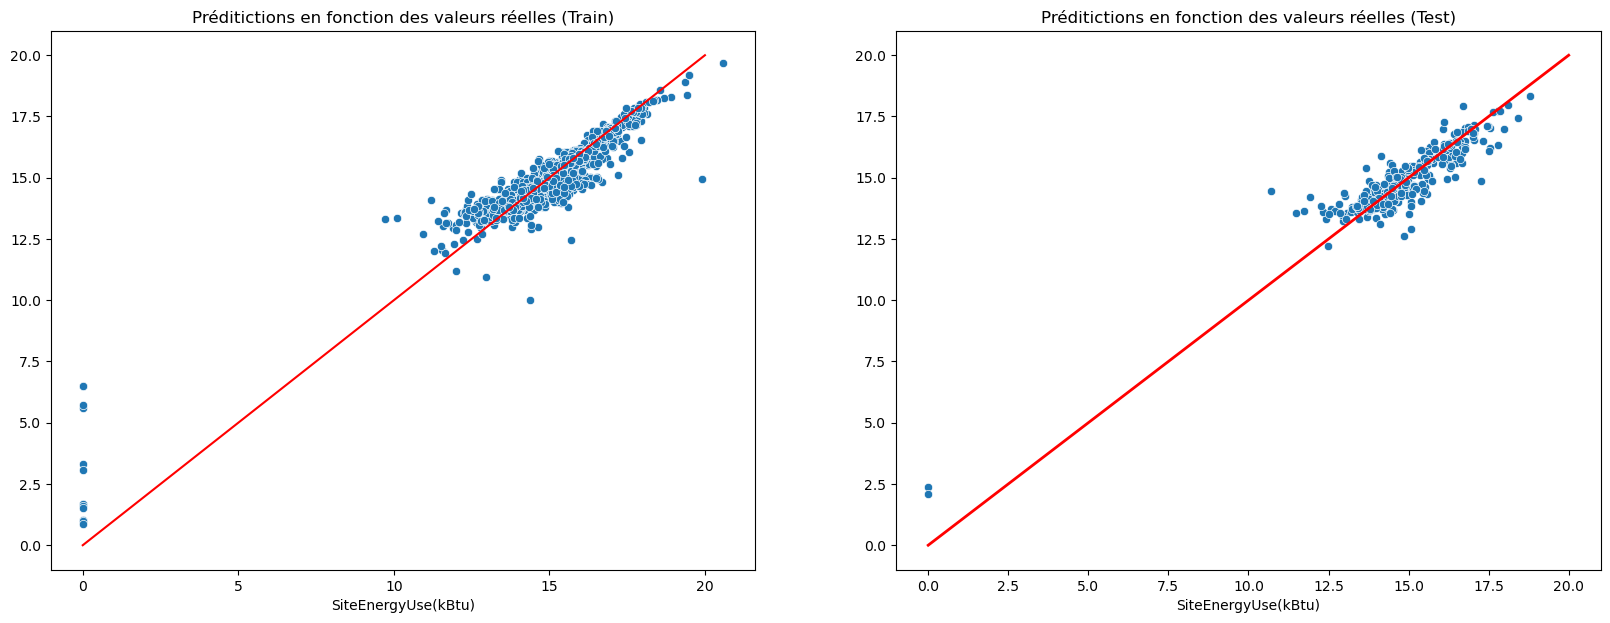

In [63]:
plt.figure(figsize = (20,7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_rfr_e )
plt.plot([0,20],[0,20],'r-')
plt.title ('Préditictions en fonction des valeurs réelles (Train)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y= yt_rfr_e)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Test)')


### Test RandomizedSearchCV

#### RandomForestRegressor

In [64]:
df_modeles_r = pd.DataFrame(columns = ['Best Param', 'Time', 'MSE_Train', 'MSE_Test','RMSE_Train', 'RMSE_Test', 'R² Train', 'R² Test'])

In [65]:
rfr_t=RandomForestRegressor(n_jobs=-1, random_state=42)
param_rfr_t ={"model__n_estimators" :list(np.arange(0,1000,100)),
             "model__max_depth" :list(np.arange(1,20,1))}

y_rfr_t, yt_rfr_t, result_rfr_t, cv_res_rfr_t = modelCV(X_train, X_test,
                                 y_train,
                                 y_test,
                                 rfr_t, 
                                 param_rfr_t, 
                                 cv, 
                                 rand=True) 
result_rfr_t

[{'model__n_estimators': 400, 'model__max_depth': 15},
 3.81,
 1.9627306813302892,
 0.4250821158323591,
 0.5321192233869427,
 0.6519832174468597,
 0.9321035516203591,
 0.8565165419166411]

In [66]:
df_modeles_r.loc['RF Regressor'] = result_rfr_t

Text(0.5, 1.0, 'Préditictions en fonction des valeurs réelles (Test)')

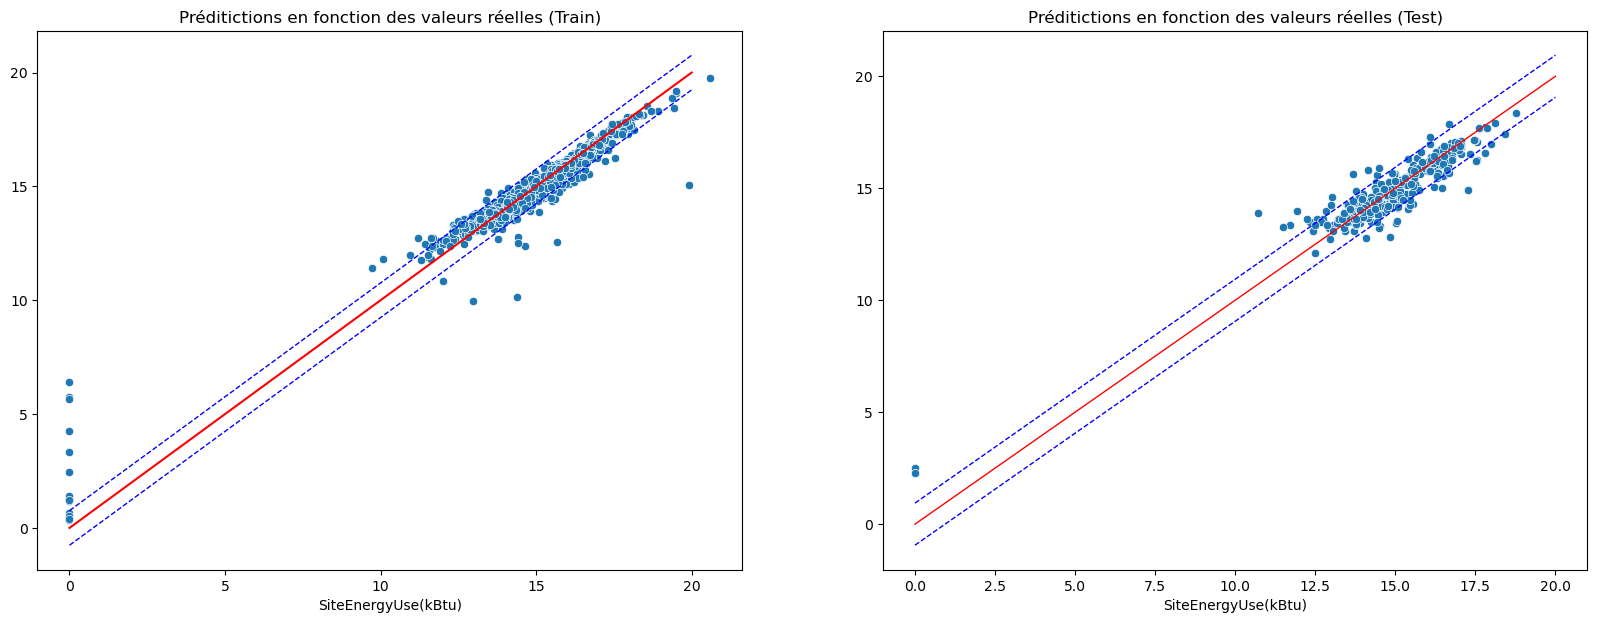

In [67]:
plt.figure(figsize = (20,7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_rfr_t )
plt.plot([0,20],[0,20],'r-')
plt.plot([0,20],[0.76,20.76],'b--', lw=1)
plt.plot([0,20],[-0.76,19.24],'b--', lw=1)
plt.title ('Préditictions en fonction des valeurs réelles (Train)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y= yt_rfr_t)
plt.plot([0,20],[0,20],'r-', lw=1)
plt.plot([0,20],[0.94,20.94],'b--', lw=1)
plt.plot([0,20],[-0.94,19.06],'b--', lw=1)
plt.title ('Préditictions en fonction des valeurs réelles (Test)')

#### LightGBM Regressor

In [68]:
param_lgbmr_t ={"model__n_estimators" :list(np.arange(0,1000,1)),
             "model__max_depth" :list(np.arange(1,20,1))}
lgbmr_t = LGBMRegressor(n_jobs=-1, random_state=43)

y_lgbmr_t, yt_lgbmr_t,result_lgbmr_t, cv_res_lgbmr_t =  modelCV(X_train, X_test,
                                 y_train,
                                 y_test,
                                 lgbmr_t, 
                                 param_lgbmr_t, 
                                 cv, 
                                 rand=True)
result_lgbmr_t

[{'model__n_estimators': 223, 'model__max_depth': 13},
 1.3,
 1.8867932962482905,
 0.7726694620728414,
 0.4824674841801564,
 0.8790161898809609,
 0.944183158307725,
 0.7391908945486141]

In [69]:
df_modeles_r.loc['LGBM Regressor'] = result_lgbmr_t

Text(0.5, 1.0, 'Préditictions en fonction des valeurs réelles (Test)')

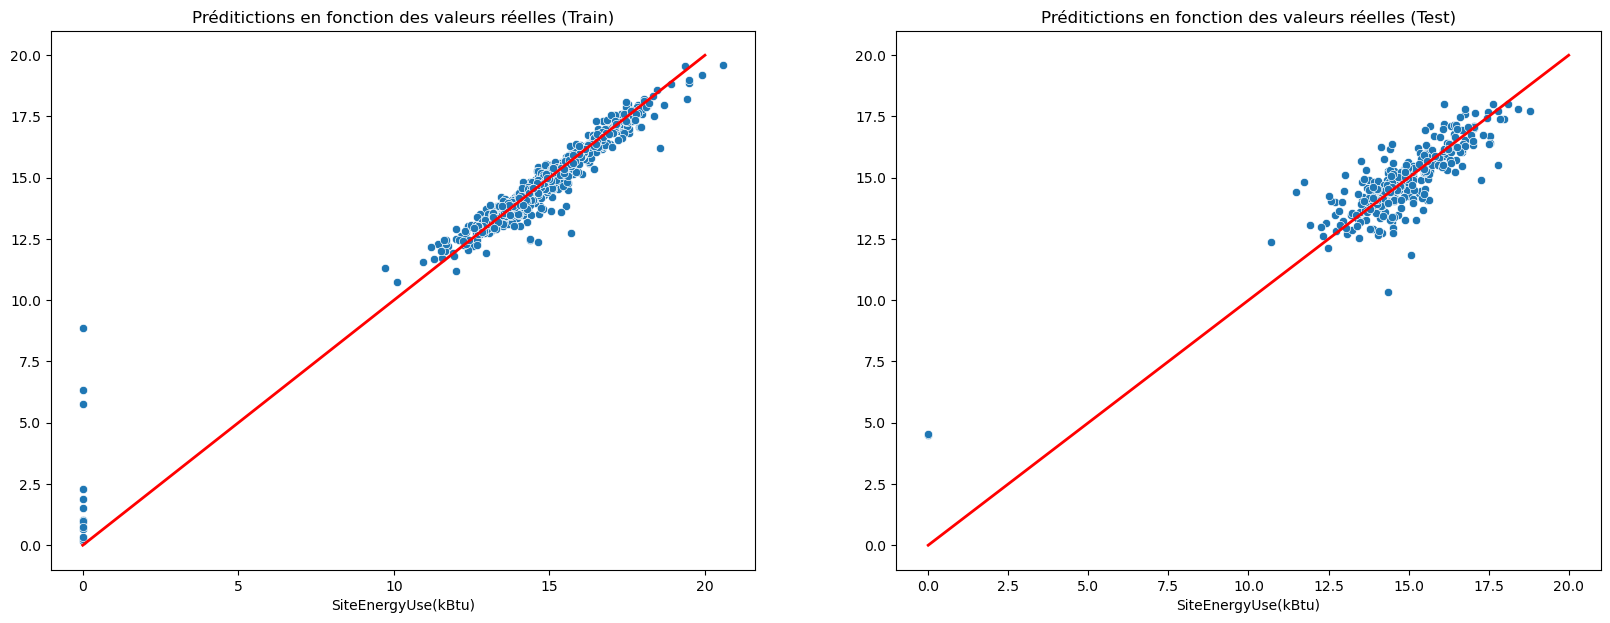

In [70]:
plt.figure(figsize = (20,7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y= y_lgbmr_t)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Train)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y= yt_lgbmr_t)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Test)')

#### XGBoost Regressor

In [92]:
param_xgb_t ={"model__n_estimators" :list(np.arange(0,1000,1)),
             "model__max_depth" :list(np.arange(1,20,1))}
xgb_t = XGBRegressor(n_jobs=-1, random_state=43)

y_xgb_t, yt_xgb_t,result_xgb_t, cv_res_xgb_t =  modelCV(X_train, X_test,
                                 y_train,
                                 y_test,
                                 xgb_t, 
                                 param_xgb_t, 
                                 cv, 
                                 rand=True)
result_xgb_t

[{'model__n_estimators': 357, 'model__max_depth': 4},
 1.7,
 1.6824068821441267,
 0.5441452519979687,
 0.08448954673517894,
 0.7376620174564831,
 0.9982882705584653,
 0.8163276234206468]

In [93]:
df_modeles_r.loc['XGB Regressor'] = result_xgb_t

In [94]:
plt.figure(figsize = (20,7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y= y_xgb_t)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Train)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y= yt_xgb_t)
plt.plot([0,20],[0,20],'r-', lw=2)
plt.title ('Préditictions en fonction des valeurs réelles (Test)')

Text(0.5, 1.0, 'Préditictions en fonction des valeurs réelles (Test)')

In [95]:
df_modeles_r

,Best Param,Time,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test,R² Train,R² Test
RF Regressor,"{'model__n_estimators': 400, 'model__max_depth...",3.81,1.962731,0.425082,0.532119,0.651983,0.932104,0.856517
LGBM Regressor,"{'model__n_estimators': 223, 'model__max_depth...",1.30,1.886793,0.772669,0.482467,0.879016,0.944183,0.739191
XGB Regressor,"{'model__n_estimators': 357, 'model__max_depth...",1.70,1.682407,0.544145,0.084490,0.737662,0.998288,0.816328


### Optimisation de Random Forest Regressor

In [75]:
rfr_o=RandomForestRegressor(n_jobs=-1, random_state=52, max_depth=18,bootstrap=True, n_estimators=610, verbose=1)

## Modèle final 

In [76]:
def ModelFinal(X,y,Xt):
    
    import eli5
    from eli5.sklearn import PermutationImportance
    
    quant = X.select_dtypes(exclude =['object']).columns
    qual = X.select_dtypes(include =['object']).columns
    
    #Transformation et Encodage
    simple= impute.SimpleImputer()
    power = preprocessing.StandardScaler()
    encoder = preprocessing.OneHotEncoder(handle_unknown = 'ignore')

    pipeline_poly = Pipeline([('simple',simple),
                              ("power", power)])

    #Transformation de colonnes
    preprocessor = ColumnTransformer(
        transformers=[("quant", pipeline_poly, quant),
                      ("qual", encoder, qual)])
    rfr_o=RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=18, bootstrap=True, n_estimators=610)

    #Pipeline modèle
    pipeline_mod = Pipeline([("preprocessor", preprocessor), 
                             ("model", rfr_o)]).fit(X,y)
    
    model = pipeline_mod.named_steps['model']
    X2 = preprocessor.transform(X)
    
    #pipeline_mod.fit(X,y)
    y_pred = pipeline_mod.predict(Xt)
    y_cross = pipeline_mod.predict(X)
    
    # Récuperer features names
    features_names = pipeline_mod.named_steps['preprocessor'].named_transformers_['qual'].get_feature_names(qual).tolist()
    features_names = features_names + quant.tolist()
    
    coef = model.fit(X2, y).feature_importances_
    
    perm = PermutationImportance(model, random_state=52).fit(X2, y)
    #eli5.show_weights(perm, feature_names = features_names)
    
    return y_pred, y_cross, pd.concat((pd.DataFrame(features_names, columns=['Nom']),\
           pd.DataFrame(coef, columns=['Coefficient'])), axis = 1).sort_values(by='Coefficient',ascending=False), perm, features_names

In [77]:
y_mod, y_cv, df_m , perm, features_names = ModelFinal(X_train, y_train, X_test)

In [78]:
round(metrics.r2_score(y_train, y_cv), 2)

0.94

#### Prédiction

R²= 0.86 
MSE= 0.42 
RMSE= 0.65


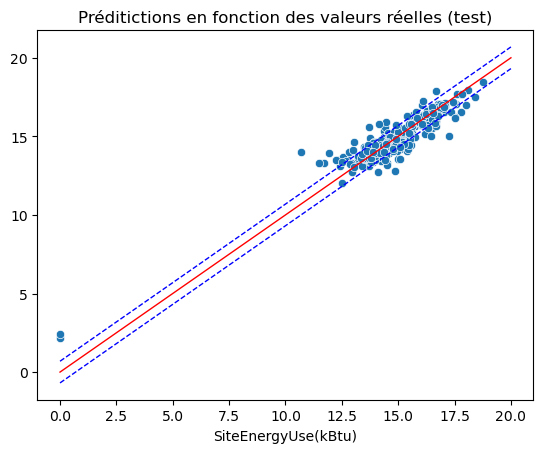

In [79]:
r2 = round(metrics.r2_score(y_test, y_mod), 2)#R² test
mse = round(metrics.mean_squared_error(y_test, y_mod),2) #MSE Test
rmse = round(metrics.mean_squared_error(y_test, y_mod, squared=False),2) #RMSE test
sns.scatterplot(x=y_test, y= y_mod)
plt.plot([0,20],[0,20],'r-', lw=1)
plt.plot([0,20],[0.69,20.69],'b--', lw=1)
plt.plot([0,20],[-0.69,19.31],'b--', lw=1)
plt.title ('Préditictions en fonction des valeurs réelles (test)')
print('R²=',r2,'\nMSE=',mse,'\nRMSE=',rmse)
plt.savefig("./Visualisations/prediction conso", bbox_inches='tight')
plt.show()

### Features Importances

In [80]:
import eli5
eli5.show_weights(perm, feature_names = features_names)

Weight,Feature
1.0259 ± 0.1263,PrimaryPropertyType_K-12 School
0.9457 ± 0.2455,PrimaryPropertyType_Senior Care Community
0.8585 ± 0.3001,PrimaryPropertyType_Large Office
0.2887 ± 0.0245,PrimaryPropertyType_Refrigerated Warehouse
0.0736 ± 0.0105,PrimaryPropertyType_Medical Office
0.0722 ± 0.0132,PrimaryPropertyType_Mixed Use Property
0.0437 ± 0.0105,PrimaryPropertyType_Distribution Center
0.0410 ± 0.0019,PropertyGFAParking
0.0194 ± 0.0053,SecondLargestPropertyUseTypeGFA
0.0147 ± 0.0025,PrimaryPropertyType_Hotel


In [81]:
import shap

 
quant = X_train.select_dtypes(exclude =['object']).columns
qual = X_train.select_dtypes(include =['object']).columns
    
#Transformation et Encodage
simple= impute.SimpleImputer()
power = preprocessing.StandardScaler()
encoder = preprocessing.OneHotEncoder(handle_unknown = 'ignore')

pipeline_poly = Pipeline([('simple',simple),
                              ("power", power)])

#Transformation de colonnes
preprocessor = ColumnTransformer(
        transformers=[("quant", pipeline_poly, quant),
                      ("qual", encoder, qual)])
rfr_o=RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=18,bootstrap=True, n_estimators=610, verbose=0)

    #Pipeline modèle
pipeline_mod = Pipeline([("preprocessor", preprocessor), 
                             ("model", rfr_o)]).fit(X_train,y_train)
    
model = pipeline_mod.named_steps['model']
X2 = preprocessor.transform(X_train)


explainer = shap.TreeExplainer(model)
shap_values = explainer(X2)

In [82]:
features_names = pipeline_mod.named_steps['preprocessor'].named_transformers_['qual'].get_feature_names(qual).tolist()
features_names = features_names + quant.tolist()

In [83]:
shap_values.feature_names = features_names

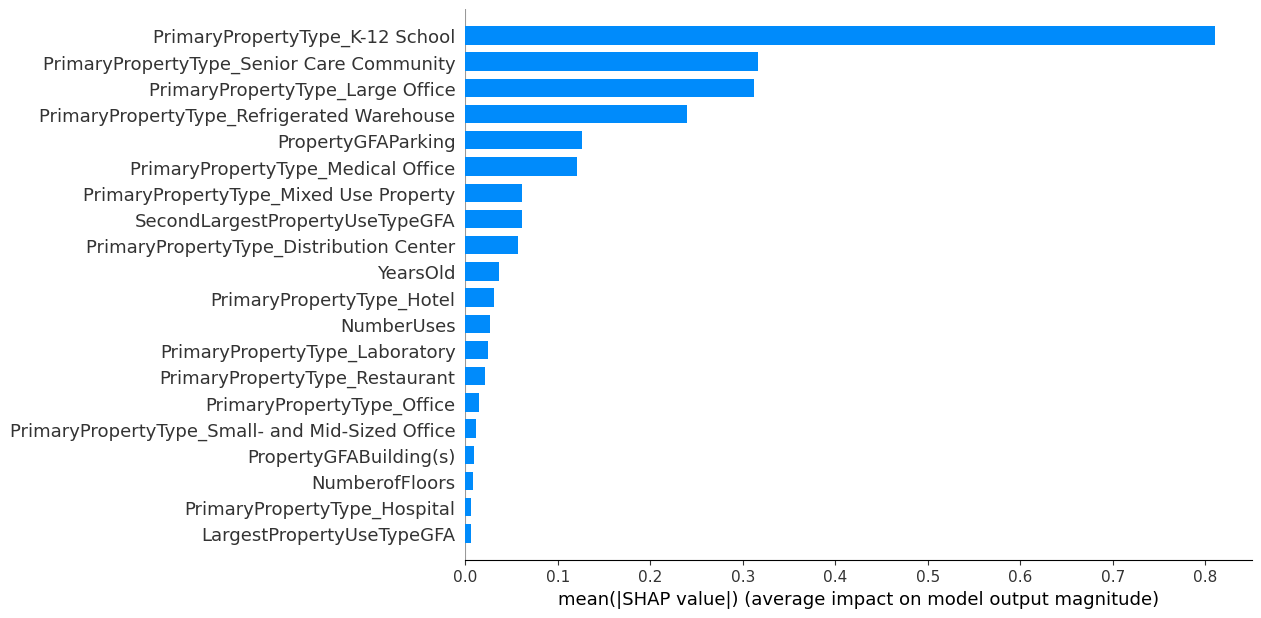

In [84]:
fig = plt.figure()
shap.summary_plot(shap_values.values, shap_values.feature_names, plot_type ='bar', show=False)
plt.gcf().set_size_inches(20,6)
plt.savefig("./Visualisations/feat shap loc conso", bbox_inches='tight')
plt.show()

In [85]:
n = X_train[qual].nunique()
n_categories = [20,1,1,1,1,1,1,1,1,1,1]

In [86]:
new_shap_values = []
for values in shap_values.values:
    
    #split shap values
    values_split = np.split(values , np.cumsum(n_categories))
    
    #somme des valeurs
    values_sum = [sum(l) for l in values_split]
    
    new_shap_values.append(values_sum)

In [87]:
shap_values.values = np.array(new_shap_values)

#remplace data 
new_data = np.array(X_train)
shap_values.data = np.array(new_data)

#mise a jour des feature names
shap_values.feature_names = list(X_train.columns)

In [88]:
shap_values.shape

(1294, 12)

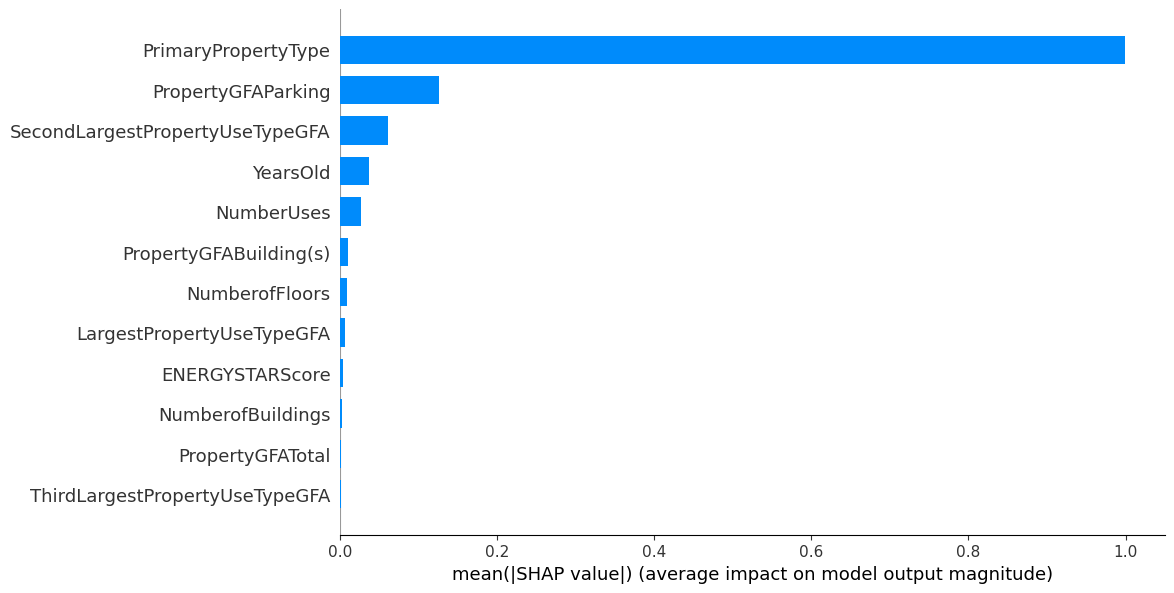

In [89]:
fig = plt.figure()
shap.summary_plot(shap_values, shap_values.data, plot_type ='bar', show=False)
plt.gcf().set_size_inches(15,6)
plt.savefig("./Visualisations/feat shap glob conso", bbox_inches='tight')
plt.show()

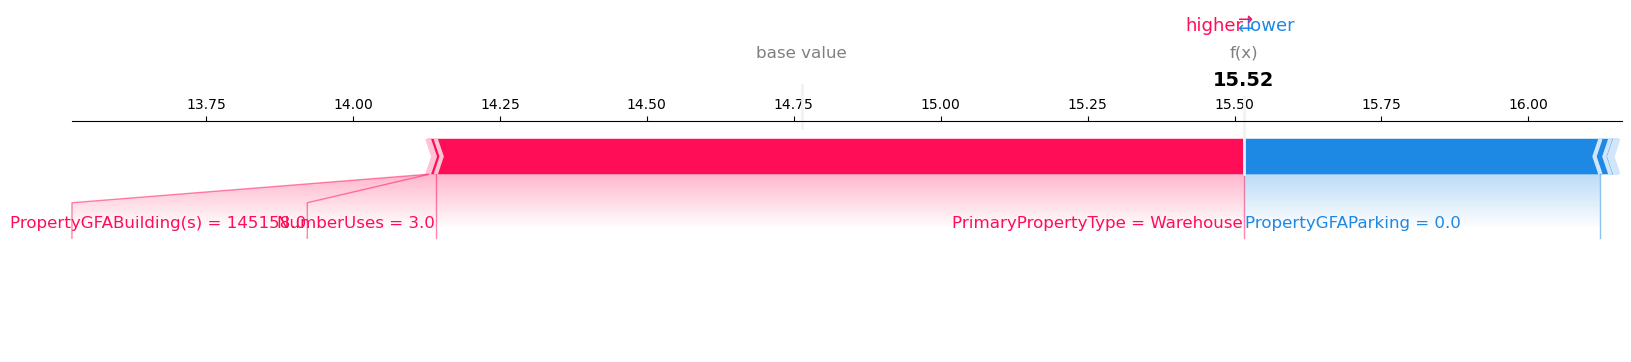

In [90]:
shap.force_plot(explainer.expected_value, shap_values.values[9], features=X_train.iloc[9], feature_names=shap_values.feature_names,show=False,matplotlib=True).savefig("./Visualisations/feat shap Forceplot conso", bbox_inches='tight')
plt.show()

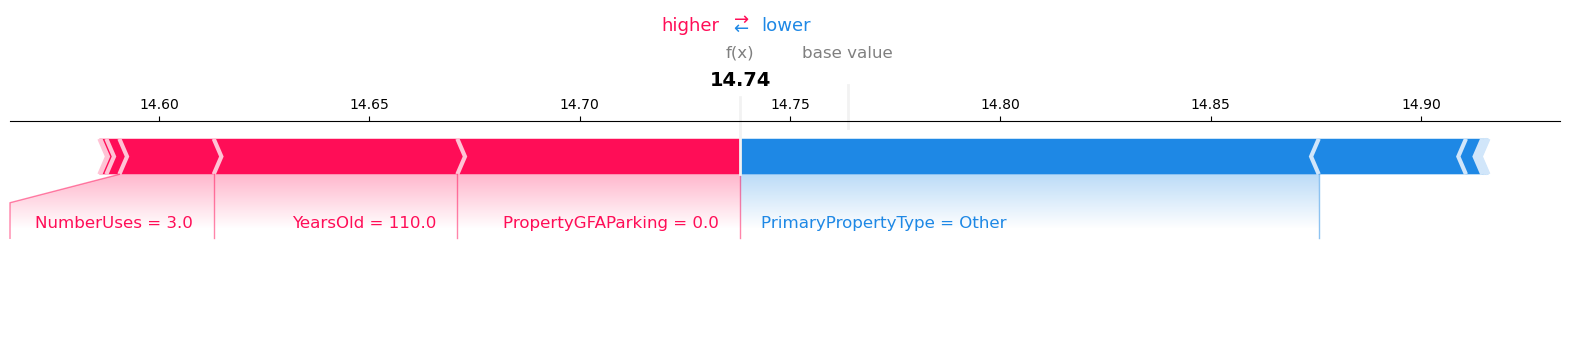

In [91]:
shap.force_plot(explainer.expected_value, shap_values.values[6], features=X_train.iloc[6], feature_names=shap_values.feature_names,show=False,matplotlib=True).savefig("./Visualisations/feat shap Forceplot conso2", bbox_inches='tight')
plt.show()